In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA, NMF
import data_processing as dp
from scipy import signal
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt
import pywt
import os
import time
import h5py
from itertools import combinations

In [2]:
for dirname, _, filenames in os.walk('.\data'):
    for filename in filenames:
        print(os.path.join(dirname,filename))

.\data\file_name.txt
.\data\G04_FoG_trial_1_emg.csv
.\data\G04_FoG_trial_2_emg.csv
.\data\G06_FoG_trial_1_emg.csv
.\data\G06_FoG_trial_2_emg.csv
.\data\G06_FoG_trial_3_emg.csv
.\data\G07_Freezing_Trial1_trial_1_emg.csv
.\data\G08_FoG_1_trial_1_emg.csv
.\data\G08_FoG_2_trial_1_emg.csv
.\data\G11_FoG_trial_1_emg.csv
.\data\G11_FoG_trial_2_emg.csv
.\data\P379_M050_2_OFF_A_FoG_trial_1_emg.csv
.\data\P379_M050_2_OFF_A_FoG_trial_2_emg.csv
.\data\P379_M050_2_OFF_A_FoG_trial_3_emg.csv
.\data\P379_M050_2_OFF_B_FoG_trial_1_emg.csv
.\data\P379_M050_2_OFF_B_FoG_trial_2_emg.csv
.\data\P379_M050_2_OFF_B_FoG_trial_3_emg.csv
.\data\P551_M050_2_A_FoG_trial_1_emg.csv
.\data\P551_M050_2_B_FoG_trial_1_emg.csv
.\data\P551_M050_2_B_FoG_trial_2_emg.csv
.\data\P812_M050_2_B_FoG_trial_1_emg.csv
.\data\P812_M050_2_B_FoG_trial_2_emg.csv
.\data\some_of_rest.txt
.\data\其他\labels.txt
.\data\其他\P812_M050_2_B_FoG_trial1_annotation.csv
.\data\其他\P812_M050_2_B_FoG_trials.mat
.\data\其他\P812_M050_2_B_FoG_trial_1_out_left

In [16]:
emg_data = pd.read_csv('.\data\P812_M050_2_B_FoG_trial_1_emg.csv')
#emg_data2 = pd.read_csv('.\data\正常\G03_Walking_trial_2_emg.csv')
path2 = '.\data\正常\P551_M50_B_Walking_trial_6_emg.csv'
#emg_data3 = pd.read_csv(path)

In [3]:
path = './processed data/data_set_after_window_withoutSC_allPa.hdf5'
with h5py.File(path,'r') as f:
    x = f['cwt_data'][...]
    y = f['label2'][...]

In [44]:
#x,y = generate_window_slide_data(emg_data)
#x2,y2 = generate_window_slide_data(emg_data2)

In [23]:
import imp
imp.reload(dp)

<module 'data_processing' from 'E:\\Document\\jupyter\\Master Thesis\\data_processing.py'>

In [4]:
import ctypes
player = ctypes.windll.kernel32
player.Beep(1000,200)

1

In [6]:
width = 256
threshold_WAMP = 30
threshold_ZC = 0
threshold_SSC = 1
bins=9
bound = 70
HIST_range = (-bound,bound)

In [6]:
feature = dp.generate_feature(x,threshold_WAMP=threshold_WAMP,
                              threshold_ZC=threshold_ZC,
                              threshold_SSC=threshold_SSC,
                              bins=bins,ranges=HIST_range)
#feature2 = dp.generate_feature(x2)
player.Beep(1000,200)

threshold_WAMP:30.0, threshold_ZC:0.0, threshold_SSC:1.0,bins:9,ranges:(-70,70)
IEMG,MAV,SSI,VAR,RMS,WL,ZC,SSC,WAMP,skew,Acti,AR,HIST


1

In [44]:
with h5py.File('./processed data/feature_restdata.hdf5','r') as f:
    feature2 = f['features'][...]
    y2 = f['labels'][...]

In [16]:
sc = StandardScaler(with_mean=True)
feature_sc = sc.fit_transform(feature)

In [46]:
x.shape

(46434, 256, 8)

In [171]:
feature2,y2 = dp.pipeline_feature(path2,width=256,scaler=False,
                                  threshold_WAMP=threshold_WAMP,
                                  threshold_ZC=threshold_ZC,
                                  threshold_SSC=threshold_SSC,
                                  bins=bins,ranges=HIST_range)
#feature2_sc = sc.transform(feature2)

threshold_WAMP:30.0, threshold_ZC:0.0, threshold_SSC:1.0,bins:9,ranges:(-70,70)
IEMG,MAV,SSI,VAR,RMS,WL,ZC,SSC,WAMP,skew,Acti,AR,HIST


In [43]:
pca = PCA(n_components=60,copy=True,whiten=True)
feature_pca = pca.fit_transform(feature)
#feature2_pca = pca.transform(feature2)

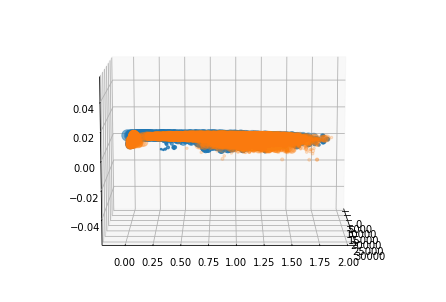

In [32]:
ind = ((y==4)|(y==1)|(y==2)|(y==3)|(y==6))
y_01 = y.copy()
y_01[ind] = 1
ind0 = y_01==0
ind1 = y_01==1
#plt.scatter(feature[ind0][:,42],feature[ind0][:,50])
#plt.scatter(feature[ind1][:,42],feature[ind1][:,50])
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=30, azim=20)
plt.scatter(feature[ind0][:,42], feature[ind0][:,93], feature[ind0][:,50],marker='o')
plt.scatter(feature[ind1][:,42], feature[ind1][:,93], feature[ind1][:,50],alpha=0.2,marker='o')
ax.view_init(elev=10,azim=0)

In [469]:
x.max(axis=1)

array([[3.1680887, 3.5473368, 2.833147 , ..., 3.5971007, 3.1422873,
        2.681295 ],
       [2.4164464, 3.5161357, 3.0189595, ..., 3.6359956, 3.178391 ,
        2.6736798],
       [2.4330943, 3.3934205, 3.1654563, ..., 4.4193835, 3.1375792,
        2.588877 ],
       ...,
       [4.342047 , 4.8141947, 3.2393596, ..., 4.987775 , 3.1128116,
        3.1066031],
       [4.7452106, 4.4620094, 3.304755 , ..., 4.9901853, 2.977572 ,
        3.0100384],
       [6.000379 , 4.358333 , 3.277154 , ..., 4.4818225, 2.9674785,
        3.0071075]], dtype=float32)

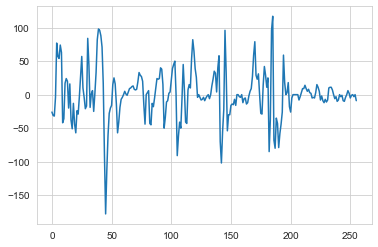

In [95]:
test=dp.compute_SSC(x,5)
#plt.figure(figsize=(32,24))
plt.plot(x[1000,:,2])
plt.grid(True)

In [2]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder

In [3]:
def train_model(model,feature,y,file=None):
    ind = ((y==4)|(y==1)|(y==2)|(y==3)|(y==6))
    y_01 = y.copy()
    y_01[ind] = 1
    x_full,x_test,y_full,y_test = train_test_split(feature,y_01,
                                                   test_size=0.2,
                                                   random_state=123,
                                                   shuffle=False)
    x_train,x_valid,y_train,y_valid = train_test_split(x_full,y_full,
                                                       test_size=0.2,
                                                       random_state=555,
                                                       shuffle=True)
    eval_set=[(x_train,y_train),(x_valid,y_valid)]
    model.fit(x_train, y_train,eval_metric=['error'],
              eval_set=eval_set,early_stopping_rounds=20)
    y_pred_t=model.predict(x_test)
    test = metrics.accuracy_score(y_test,y_pred_t)
    y_pred_v=model.predict(x_valid)
    valid = metrics.accuracy_score(y_valid,y_pred_v)
    y_pred_ta=model.predict(x_train)
    train = metrics.accuracy_score(y_train,y_pred_ta)
    print('test:%f'%test)
    print('valid:%f'%valid)
    print('train:%f'%train)
    if file != None:
        model.save_model(file)
    return train,valid,test

def test_model(model,feature,y):
    ind = ((y==4)|(y==1)|(y==2)|(y==3)|(y==6))
    y_01 = y.copy()
    y_01[ind] = 1
    y_pred=model.predict(feature)
    test = metrics.accuracy_score(y_01,y_pred>0.5)
    print('acc:%f'%test)
    return test

def test_load_model(path,feature,y):
    ind = ((y==4)|(y==1)|(y==2)|(y==3)|(y==6))
    y_01 = y.copy()
    y_01[ind] = 1
    booster = xgb.Booster()
    booster.load_model(path)
    model = xgb.XGBClassifier()
    model._Booster = booster
    y_pred=model.predict(feature)
    test = metrics.accuracy_score(y_01,y_pred>0.5)
    print('acc:%f'%test)
    return test

In [12]:
lc = LabelEncoder()
#ind = ((y==1)|(y==2)|(y==3)|(y==6))
#y_01 = y[ind].copy()
#y_01 = lc.fit_transform(y_01)
ind = ((y==4)|(y==1)|(y==2)|(y==3)|(y==6))
y_01 = y.copy()
y_01[ind] = 1
oh_ec = OneHotEncoder()
#y_oh = oh_ec.fit_transform(y_01[:,np.newaxis]).toarray()
x_full,x_test,y_full,y_test = train_test_split(feature,y_01,test_size=0.2,random_state=123,shuffle=False)
x_train,x_valid,y_train,y_valid = train_test_split(x_full,y_full,test_size=0.2,random_state=555,shuffle=True)
d_train = xgb.DMatrix(x_train,label=y_train)
d_valid = xgb.DMatrix(x_valid,label=y_valid)

In [ ]:
param = {'max_depth': 5, 'eta': 0.3, 'gamma':0}
#param['nthread'] = 4
param['seed'] = 100
param['objective'] = 'binary:logistic'
#param['objectibe'] = 'multi:softmax'
#param['num_class'] = 4
param['lambda'] = 2
param['subsample'] = 0.8
evallist = [(d_train, 'train'), (d_valid, 'eval')]

model = xgb.train(param, d_train, 1000, evallist,early_stopping_rounds=30)
player.Beep(1000,200)

In [4]:
model = xgb.XGBClassifier(max_depth=4, 
                          learning_rate=0.3, 
                          n_estimators=1000, 
                          silent=True, 
                          eval_metrics='error',
                          objective='binary:logistic', 
                          #objective='multi:softmax',
                          #num_calss=4,
                          seed=100,
#                          nthread=4,
                          sub_sabsample=0.8,
                          reg_lambda = 15,
                         )
#train,valid,test = train_model(model,feature,y)
#print([train,valid,test])
#player.Beep(1000,200)

In [19]:
pd.Series(y).value_counts()

[0.9992720820727463, 0.9738877263215358, 0.9355073518707235]


In [131]:
acc={}
#widths = [128,256,512]
widths = [256]
for width in widths:
    stride = width//4
    file = './processed data/features_W%d_S%d.hdf5'%(width,stride)
    with h5py.File(file,'r') as f:
        feature = f['features'][...]
        y = f['labels'][...]
    #model_file = './model/XGBoost_W%d_S%d.json'%(width,stride)
    #pca = PCA(n_components=100,copy=True)
    #feature_pca = pca.fit_transform(feature)
    train,valid,test = train_model(model,feature[:,:],y)
    acc['W%d'%width] = [train,valid,test]
    
    file = './processed data/features_rest_W%d_S%d.hdf5'%(width,stride)
    with h5py.File(file,'r') as f:
        feature2 = f['features'][...]
        y2 = f['labels'][...]
    #test_load_model(model_file,feature2,y2)
    #feature2_pca = pca.transform(feature2)
    acc_rest=[test_model(model,feature2[:,:],y2)]
    print(acc_rest)

[23:29:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { eval_metrics, silent, sub_sabsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.21751	validation_1-error:0.22481
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.17999	validation_1-error:0.18843
[2]	validation_0-error:0.15552	validation_1-error:0.16606
[3]	validation_0-error:0.14325	validation_1-error:0.15169
[4]	validation_0-error:0.13702	validation_1-error:0.14551
[5]	validation_0-error:0.13092	validation_1-error:0.13332
[6]	validation_0-error:0.12401	validation_1-error:0.12732
[7]	validation_0-err

[129]	validation_0-error:0.02883	validation_1-error:0.06548
[130]	validation_0-error:0.02869	validation_1-error:0.06512
[131]	validation_0-error:0.02842	validation_1-error:0.06493
[132]	validation_0-error:0.02824	validation_1-error:0.06439
[133]	validation_0-error:0.02810	validation_1-error:0.06493
[134]	validation_0-error:0.02792	validation_1-error:0.06439
[135]	validation_0-error:0.02756	validation_1-error:0.06384
[136]	validation_0-error:0.02760	validation_1-error:0.06420
[137]	validation_0-error:0.02769	validation_1-error:0.06475
[138]	validation_0-error:0.02715	validation_1-error:0.06457
[139]	validation_0-error:0.02688	validation_1-error:0.06530
[140]	validation_0-error:0.02660	validation_1-error:0.06530
[141]	validation_0-error:0.02551	validation_1-error:0.06402
[142]	validation_0-error:0.02533	validation_1-error:0.06384
[143]	validation_0-error:0.02460	validation_1-error:0.06475
[144]	validation_0-error:0.02474	validation_1-error:0.06384
[145]	validation_0-error:0.02401	validat

(34360, 168)

In [63]:
#test feature from Left or Right

acc={}
cols = ['Left','Right']
for col in cols:
    stride = width//4
    file = './processed data/'+col+'_features_W256_S64.hdf5'
    with h5py.File(file,'r') as f:
        feature = f['features'][...]
        y = f['labels'][...]
    model_file = './model/XGBoost_W%d_S%d_'%(width,stride)+col+'.json'
    train,valid,test = train_model(model,feature,y,model_file)
    acc[col] = [train,valid,test]
    file = './processed data/'+col+'_features_rest_W256_S64.hdf5'
    with h5py.File(file,'r') as f:
        feature2 = f['features'][...]
        y2 = f['labels'][...]
    acc_rest=[test_model(model,feature2,y2)]
    print(acc_rest)

[0]	validation_0-error:0.17626	validation_1-error:0.18916
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.15607	validation_1-error:0.17297
[2]	validation_0-error:0.14106	validation_1-error:0.15697
[3]	validation_0-error:0.13520	validation_1-error:0.14896
[4]	validation_0-error:0.13079	validation_1-error:0.14387
[5]	validation_0-error:0.12669	validation_1-error:0.14187
[6]	validation_0-error:0.11951	validation_1-error:0.13641
[7]	validation_0-error:0.11582	validation_1-error:0.13314
[8]	validation_0-error:0.11182	validation_1-error:0.13059
[9]	validation_0-error:0.10973	validation_1-error:0.12787
[10]	validation_0-error:0.10514	validation_1-error:0.12805
[11]	validation_0-error:0.10277	validation_1-error:0.12732
[12]	validation_0-error:0.09964	validation_1-error:0.12459
[13]	validation_0-error:0.09704	validation_1-error:0.12350
[14]	validation_0-error

[33]	validation_0-error:0.06667	validation_1-error:0.10822
[34]	validation_0-error:0.06453	validation_1-error:0.10731
[35]	validation_0-error:0.06312	validation_1-error:0.10768
[36]	validation_0-error:0.06076	validation_1-error:0.10386
[37]	validation_0-error:0.06071	validation_1-error:0.10276
[38]	validation_0-error:0.05921	validation_1-error:0.10167
[39]	validation_0-error:0.05653	validation_1-error:0.10131
[40]	validation_0-error:0.05571	validation_1-error:0.10022
[41]	validation_0-error:0.05543	validation_1-error:0.10022
[42]	validation_0-error:0.05271	validation_1-error:0.09895
[43]	validation_0-error:0.05161	validation_1-error:0.09822
[44]	validation_0-error:0.05061	validation_1-error:0.09840
[45]	validation_0-error:0.05007	validation_1-error:0.09840
[46]	validation_0-error:0.05007	validation_1-error:0.09694
[47]	validation_0-error:0.04711	validation_1-error:0.09713
[48]	validation_0-error:0.04611	validation_1-error:0.09749
[49]	validation_0-error:0.04516	validation_1-error:0.096

In [94]:
#test features from 2 of 8 signals

acc_2f={}
cols = [ 'LEFT_TA','LEFT_TS','LEFT_BF', 'LEFT_RF',
        'RIGHT_TA','RIGHT_TS','RIGHT_BF', 'RIGHT_RF']
for p in combinations(cols,2):
    stride = width//4
    #file = './processed data/features_W%d_S%d.hdf5'%(width,stride)
    file = './processed data/2feature/'+p[0]+p[1]+'_features_W256_S64.hdf5'
    with h5py.File(file,'r') as f:
        feature = f['features'][...]
        y = f['labels'][...]
    #model_file = './model/XGBoost_W%d_S%d.json'%(width,stride)
    train,valid,test = train_model(model,feature,y)
    acc_2f[p[0]+'_'+p[1]] = [train,valid,test]

[22:28:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { eval_metrics, silent, sub_sabsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.28017	validation_1-error:0.29247
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.26758	validation_1-error:0.27665
[2]	validation_0-error:0.25503	validation_1-error:0.26737
[3]	validation_0-error:0.24779	validation_1-error:0.26119
[4]	validation_0-error:0.24998	validation_1-error:0.25846
[5]	validation_0-error:0.24384	validation_1-error:0.25627
[6]	validation_0-error:0.23915	validation_1-error:0.25300
[7]	validation_0-err

[129]	validation_0-error:0.12155	validation_1-error:0.17570
[130]	validation_0-error:0.12115	validation_1-error:0.17479
[131]	validation_0-error:0.12055	validation_1-error:0.17516
[132]	validation_0-error:0.11955	validation_1-error:0.17497
[133]	validation_0-error:0.11960	validation_1-error:0.17534
[134]	validation_0-error:0.11942	validation_1-error:0.17534
[135]	validation_0-error:0.11910	validation_1-error:0.17497
[136]	validation_0-error:0.11883	validation_1-error:0.17497
[137]	validation_0-error:0.11860	validation_1-error:0.17534
[138]	validation_0-error:0.11855	validation_1-error:0.17570
[139]	validation_0-error:0.11751	validation_1-error:0.17443
[140]	validation_0-error:0.11728	validation_1-error:0.17479
[141]	validation_0-error:0.11714	validation_1-error:0.17406
[142]	validation_0-error:0.11619	validation_1-error:0.17370
[143]	validation_0-error:0.11578	validation_1-error:0.17352
[144]	validation_0-error:0.11578	validation_1-error:0.17297
[145]	validation_0-error:0.11582	validat

[266]	validation_0-error:0.08058	validation_1-error:0.15824
[267]	validation_0-error:0.08035	validation_1-error:0.15806
[268]	validation_0-error:0.07995	validation_1-error:0.15824
[269]	validation_0-error:0.08004	validation_1-error:0.15769
[270]	validation_0-error:0.07990	validation_1-error:0.15806
[271]	validation_0-error:0.07976	validation_1-error:0.15697
[272]	validation_0-error:0.07954	validation_1-error:0.15715
[273]	validation_0-error:0.07931	validation_1-error:0.15751
[274]	validation_0-error:0.07926	validation_1-error:0.15715
[275]	validation_0-error:0.07876	validation_1-error:0.15715
[276]	validation_0-error:0.07899	validation_1-error:0.15715
[277]	validation_0-error:0.07895	validation_1-error:0.15715
[278]	validation_0-error:0.07863	validation_1-error:0.15697
[279]	validation_0-error:0.07881	validation_1-error:0.15733
[280]	validation_0-error:0.07840	validation_1-error:0.15697
[281]	validation_0-error:0.07822	validation_1-error:0.15697
[282]	validation_0-error:0.07803	validat

[403]	validation_0-error:0.05548	validation_1-error:0.15333
[404]	validation_0-error:0.05543	validation_1-error:0.15315
[405]	validation_0-error:0.05466	validation_1-error:0.15333
[406]	validation_0-error:0.05430	validation_1-error:0.15369
Stopping. Best iteration:
[376]	validation_0-error:0.05835	validation_1-error:0.15024

test:0.791909
valid:0.849764
train:0.941655
[22:28:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { eval_metrics, silent, sub_sabsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.24275	validation_1-error:0.25500
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 round

[123]	validation_0-error:0.10286	validation_1-error:0.14714
[124]	validation_0-error:0.10250	validation_1-error:0.14678
[125]	validation_0-error:0.10255	validation_1-error:0.14678
[126]	validation_0-error:0.10200	validation_1-error:0.14605
[127]	validation_0-error:0.10136	validation_1-error:0.14678
[128]	validation_0-error:0.10105	validation_1-error:0.14678
[129]	validation_0-error:0.10068	validation_1-error:0.14660
[130]	validation_0-error:0.10023	validation_1-error:0.14696
[131]	validation_0-error:0.10009	validation_1-error:0.14642
[132]	validation_0-error:0.09991	validation_1-error:0.14660
[133]	validation_0-error:0.09982	validation_1-error:0.14642
[134]	validation_0-error:0.09873	validation_1-error:0.14551
[135]	validation_0-error:0.09909	validation_1-error:0.14423
[136]	validation_0-error:0.09904	validation_1-error:0.14496
[137]	validation_0-error:0.09900	validation_1-error:0.14605
[138]	validation_0-error:0.09873	validation_1-error:0.14660
[139]	validation_0-error:0.09818	validat

[260]	validation_0-error:0.06835	validation_1-error:0.13223
[261]	validation_0-error:0.06826	validation_1-error:0.13205
[262]	validation_0-error:0.06835	validation_1-error:0.13205
[263]	validation_0-error:0.06808	validation_1-error:0.13241
[264]	validation_0-error:0.06844	validation_1-error:0.13187
[265]	validation_0-error:0.06835	validation_1-error:0.13187
[266]	validation_0-error:0.06835	validation_1-error:0.13205
[267]	validation_0-error:0.06830	validation_1-error:0.13205
[268]	validation_0-error:0.06835	validation_1-error:0.13223
[269]	validation_0-error:0.06839	validation_1-error:0.13278
[270]	validation_0-error:0.06826	validation_1-error:0.13259
[271]	validation_0-error:0.06821	validation_1-error:0.13278
[272]	validation_0-error:0.06771	validation_1-error:0.13296
[273]	validation_0-error:0.06699	validation_1-error:0.13278
[274]	validation_0-error:0.06671	validation_1-error:0.13278
[275]	validation_0-error:0.06653	validation_1-error:0.13241
[276]	validation_0-error:0.06649	validat

[28]	validation_0-error:0.16876	validation_1-error:0.18916
[29]	validation_0-error:0.16776	validation_1-error:0.18789
[30]	validation_0-error:0.16703	validation_1-error:0.18789
[31]	validation_0-error:0.16567	validation_1-error:0.18916
[32]	validation_0-error:0.16507	validation_1-error:0.18789
[33]	validation_0-error:0.16485	validation_1-error:0.18679
[34]	validation_0-error:0.16403	validation_1-error:0.18734
[35]	validation_0-error:0.16330	validation_1-error:0.18716
[36]	validation_0-error:0.16226	validation_1-error:0.18643
[37]	validation_0-error:0.16171	validation_1-error:0.18752
[38]	validation_0-error:0.16194	validation_1-error:0.18625
[39]	validation_0-error:0.16080	validation_1-error:0.18498
[40]	validation_0-error:0.15930	validation_1-error:0.18370
[41]	validation_0-error:0.15875	validation_1-error:0.18243
[42]	validation_0-error:0.15716	validation_1-error:0.18079
[43]	validation_0-error:0.15580	validation_1-error:0.18007
[44]	validation_0-error:0.15412	validation_1-error:0.179

[166]	validation_0-error:0.10341	validation_1-error:0.15806
[167]	validation_0-error:0.10327	validation_1-error:0.15788
[168]	validation_0-error:0.10250	validation_1-error:0.15951
[169]	validation_0-error:0.10155	validation_1-error:0.15733
[170]	validation_0-error:0.10105	validation_1-error:0.15751
[171]	validation_0-error:0.10032	validation_1-error:0.15788
[172]	validation_0-error:0.10018	validation_1-error:0.15751
[173]	validation_0-error:0.09996	validation_1-error:0.15806
[174]	validation_0-error:0.09959	validation_1-error:0.15788
[175]	validation_0-error:0.09959	validation_1-error:0.15733
[176]	validation_0-error:0.09923	validation_1-error:0.15769
[177]	validation_0-error:0.09845	validation_1-error:0.15806
[178]	validation_0-error:0.09768	validation_1-error:0.15806
[179]	validation_0-error:0.09659	validation_1-error:0.15660
[180]	validation_0-error:0.09636	validation_1-error:0.15624
[181]	validation_0-error:0.09641	validation_1-error:0.15588
[182]	validation_0-error:0.09636	validat

[303]	validation_0-error:0.06635	validation_1-error:0.14824
[304]	validation_0-error:0.06658	validation_1-error:0.14860
[305]	validation_0-error:0.06653	validation_1-error:0.14860
[306]	validation_0-error:0.06626	validation_1-error:0.14860
[307]	validation_0-error:0.06599	validation_1-error:0.14878
[308]	validation_0-error:0.06612	validation_1-error:0.14933
[309]	validation_0-error:0.06548	validation_1-error:0.14933
[310]	validation_0-error:0.06517	validation_1-error:0.14914
[311]	validation_0-error:0.06507	validation_1-error:0.14914
[312]	validation_0-error:0.06476	validation_1-error:0.14933
[313]	validation_0-error:0.06380	validation_1-error:0.14933
[314]	validation_0-error:0.06316	validation_1-error:0.14860
[315]	validation_0-error:0.06321	validation_1-error:0.14842
[316]	validation_0-error:0.06316	validation_1-error:0.14842
[317]	validation_0-error:0.06257	validation_1-error:0.14896
[318]	validation_0-error:0.06253	validation_1-error:0.14914
[319]	validation_0-error:0.06239	validat

[75]	validation_0-error:0.12469	validation_1-error:0.14896
[76]	validation_0-error:0.12328	validation_1-error:0.14951
[77]	validation_0-error:0.12301	validation_1-error:0.14860
[78]	validation_0-error:0.12269	validation_1-error:0.14787
[79]	validation_0-error:0.12224	validation_1-error:0.14751
[80]	validation_0-error:0.12228	validation_1-error:0.14660
[81]	validation_0-error:0.12155	validation_1-error:0.14787
[82]	validation_0-error:0.12092	validation_1-error:0.14678
[83]	validation_0-error:0.12069	validation_1-error:0.14769
[84]	validation_0-error:0.11992	validation_1-error:0.14787
[85]	validation_0-error:0.11883	validation_1-error:0.14824
[86]	validation_0-error:0.11828	validation_1-error:0.14733
[87]	validation_0-error:0.11724	validation_1-error:0.14678
[88]	validation_0-error:0.11610	validation_1-error:0.14478
[89]	validation_0-error:0.11596	validation_1-error:0.14496
[90]	validation_0-error:0.11601	validation_1-error:0.14496
[91]	validation_0-error:0.11528	validation_1-error:0.143

[212]	validation_0-error:0.07667	validation_1-error:0.12677
[213]	validation_0-error:0.07622	validation_1-error:0.12696
[214]	validation_0-error:0.07585	validation_1-error:0.12696
[215]	validation_0-error:0.07544	validation_1-error:0.12714
[216]	validation_0-error:0.07535	validation_1-error:0.12732
[217]	validation_0-error:0.07499	validation_1-error:0.12659
[218]	validation_0-error:0.07472	validation_1-error:0.12659
[219]	validation_0-error:0.07444	validation_1-error:0.12696
[220]	validation_0-error:0.07390	validation_1-error:0.12696
[221]	validation_0-error:0.07340	validation_1-error:0.12586
[222]	validation_0-error:0.07322	validation_1-error:0.12568
[223]	validation_0-error:0.07308	validation_1-error:0.12568
[224]	validation_0-error:0.07308	validation_1-error:0.12605
[225]	validation_0-error:0.07281	validation_1-error:0.12659
[226]	validation_0-error:0.07303	validation_1-error:0.12696
[227]	validation_0-error:0.07281	validation_1-error:0.12641
[228]	validation_0-error:0.07276	validat

[102]	validation_0-error:0.10669	validation_1-error:0.14969
[103]	validation_0-error:0.10650	validation_1-error:0.14914
[104]	validation_0-error:0.10659	validation_1-error:0.14933
[105]	validation_0-error:0.10632	validation_1-error:0.14896
[106]	validation_0-error:0.10628	validation_1-error:0.14878
[107]	validation_0-error:0.10527	validation_1-error:0.14878
[108]	validation_0-error:0.10418	validation_1-error:0.14805
[109]	validation_0-error:0.10464	validation_1-error:0.14769
[110]	validation_0-error:0.10450	validation_1-error:0.14751
[111]	validation_0-error:0.10373	validation_1-error:0.14824
[112]	validation_0-error:0.10355	validation_1-error:0.14696
[113]	validation_0-error:0.10364	validation_1-error:0.14678
[114]	validation_0-error:0.10246	validation_1-error:0.14587
[115]	validation_0-error:0.10250	validation_1-error:0.14678
[116]	validation_0-error:0.10132	validation_1-error:0.14733
[117]	validation_0-error:0.10123	validation_1-error:0.14733
[118]	validation_0-error:0.10050	validat

[239]	validation_0-error:0.06935	validation_1-error:0.13896
[240]	validation_0-error:0.06944	validation_1-error:0.13896
[241]	validation_0-error:0.06903	validation_1-error:0.13878
[242]	validation_0-error:0.06912	validation_1-error:0.13860
[243]	validation_0-error:0.06889	validation_1-error:0.13860
[244]	validation_0-error:0.06876	validation_1-error:0.13932
[245]	validation_0-error:0.06812	validation_1-error:0.13987
[246]	validation_0-error:0.06799	validation_1-error:0.13987
[247]	validation_0-error:0.06739	validation_1-error:0.13878
[248]	validation_0-error:0.06749	validation_1-error:0.13787
[249]	validation_0-error:0.06721	validation_1-error:0.13750
[250]	validation_0-error:0.06658	validation_1-error:0.13732
[251]	validation_0-error:0.06676	validation_1-error:0.13714
[252]	validation_0-error:0.06653	validation_1-error:0.13732
[253]	validation_0-error:0.06649	validation_1-error:0.13696
[254]	validation_0-error:0.06589	validation_1-error:0.13696
[255]	validation_0-error:0.06612	validat

[376]	validation_0-error:0.04498	validation_1-error:0.12896
[377]	validation_0-error:0.04434	validation_1-error:0.12877
[378]	validation_0-error:0.04420	validation_1-error:0.12896
[379]	validation_0-error:0.04407	validation_1-error:0.12932
[380]	validation_0-error:0.04361	validation_1-error:0.12914
[381]	validation_0-error:0.04343	validation_1-error:0.12914
[382]	validation_0-error:0.04347	validation_1-error:0.12914
[383]	validation_0-error:0.04379	validation_1-error:0.12896
[384]	validation_0-error:0.04338	validation_1-error:0.12968
[385]	validation_0-error:0.04329	validation_1-error:0.12914
[386]	validation_0-error:0.04311	validation_1-error:0.12914
[387]	validation_0-error:0.04311	validation_1-error:0.12841
[388]	validation_0-error:0.04320	validation_1-error:0.12841
[389]	validation_0-error:0.04311	validation_1-error:0.12805
[390]	validation_0-error:0.04311	validation_1-error:0.12787
[391]	validation_0-error:0.04297	validation_1-error:0.12841
[392]	validation_0-error:0.04297	validat

[101]	validation_0-error:0.10950	validation_1-error:0.14423
[102]	validation_0-error:0.10969	validation_1-error:0.14423
[103]	validation_0-error:0.10919	validation_1-error:0.14423
[104]	validation_0-error:0.10869	validation_1-error:0.14442
[105]	validation_0-error:0.10782	validation_1-error:0.14587
[106]	validation_0-error:0.10750	validation_1-error:0.14569
[107]	validation_0-error:0.10723	validation_1-error:0.14624
[108]	validation_0-error:0.10746	validation_1-error:0.14569
[109]	validation_0-error:0.10709	validation_1-error:0.14533
[110]	validation_0-error:0.10705	validation_1-error:0.14551
[111]	validation_0-error:0.10641	validation_1-error:0.14478
[112]	validation_0-error:0.10628	validation_1-error:0.14478
[113]	validation_0-error:0.10600	validation_1-error:0.14423
[114]	validation_0-error:0.10559	validation_1-error:0.14442
[115]	validation_0-error:0.10582	validation_1-error:0.14478
[116]	validation_0-error:0.10473	validation_1-error:0.14442
[117]	validation_0-error:0.10441	validat

[39]	validation_0-error:0.15134	validation_1-error:0.16970
[40]	validation_0-error:0.14975	validation_1-error:0.17043
[41]	validation_0-error:0.14893	validation_1-error:0.17006
[42]	validation_0-error:0.14743	validation_1-error:0.16861
[43]	validation_0-error:0.14648	validation_1-error:0.16915
[44]	validation_0-error:0.14588	validation_1-error:0.16879
[45]	validation_0-error:0.14525	validation_1-error:0.16788
[46]	validation_0-error:0.14457	validation_1-error:0.16751
[47]	validation_0-error:0.14361	validation_1-error:0.16733
[48]	validation_0-error:0.14320	validation_1-error:0.16679
[49]	validation_0-error:0.14275	validation_1-error:0.16715
[50]	validation_0-error:0.14334	validation_1-error:0.16606
[51]	validation_0-error:0.14197	validation_1-error:0.16624
[52]	validation_0-error:0.14102	validation_1-error:0.16533
[53]	validation_0-error:0.14038	validation_1-error:0.16424
[54]	validation_0-error:0.13956	validation_1-error:0.16351
[55]	validation_0-error:0.13993	validation_1-error:0.163

[177]	validation_0-error:0.09532	validation_1-error:0.14242
[178]	validation_0-error:0.09454	validation_1-error:0.14205
[179]	validation_0-error:0.09477	validation_1-error:0.14169
[180]	validation_0-error:0.09432	validation_1-error:0.14223
[181]	validation_0-error:0.09436	validation_1-error:0.14205
[182]	validation_0-error:0.09391	validation_1-error:0.14205
[183]	validation_0-error:0.09381	validation_1-error:0.14242
[184]	validation_0-error:0.09345	validation_1-error:0.14223
[185]	validation_0-error:0.09268	validation_1-error:0.14151
[186]	validation_0-error:0.09227	validation_1-error:0.14005
[187]	validation_0-error:0.09222	validation_1-error:0.14023
[188]	validation_0-error:0.09163	validation_1-error:0.14023
[189]	validation_0-error:0.09141	validation_1-error:0.14060
[190]	validation_0-error:0.09090	validation_1-error:0.14023
[191]	validation_0-error:0.09081	validation_1-error:0.14023
[192]	validation_0-error:0.09081	validation_1-error:0.14023
[193]	validation_0-error:0.09045	validat

[32]	validation_0-error:0.16071	validation_1-error:0.17534
[33]	validation_0-error:0.15889	validation_1-error:0.17479
[34]	validation_0-error:0.15771	validation_1-error:0.17243
[35]	validation_0-error:0.15721	validation_1-error:0.17224
[36]	validation_0-error:0.15653	validation_1-error:0.17188
[37]	validation_0-error:0.15593	validation_1-error:0.17243
[38]	validation_0-error:0.15443	validation_1-error:0.17043
[39]	validation_0-error:0.15380	validation_1-error:0.17170
[40]	validation_0-error:0.15280	validation_1-error:0.17133
[41]	validation_0-error:0.15284	validation_1-error:0.16861
[42]	validation_0-error:0.15048	validation_1-error:0.16679
[43]	validation_0-error:0.14961	validation_1-error:0.16533
[44]	validation_0-error:0.14925	validation_1-error:0.16551
[45]	validation_0-error:0.14784	validation_1-error:0.16533
[46]	validation_0-error:0.14716	validation_1-error:0.16533
[47]	validation_0-error:0.14584	validation_1-error:0.16570
[48]	validation_0-error:0.14434	validation_1-error:0.164

[52]	validation_0-error:0.15825	validation_1-error:0.17552
[53]	validation_0-error:0.15807	validation_1-error:0.17570
[54]	validation_0-error:0.15762	validation_1-error:0.17588
[55]	validation_0-error:0.15725	validation_1-error:0.17643
[56]	validation_0-error:0.15589	validation_1-error:0.17606
[57]	validation_0-error:0.15539	validation_1-error:0.17588
[58]	validation_0-error:0.15525	validation_1-error:0.17479
[59]	validation_0-error:0.15462	validation_1-error:0.17461
[60]	validation_0-error:0.15398	validation_1-error:0.17679
[61]	validation_0-error:0.15307	validation_1-error:0.17697
[62]	validation_0-error:0.15193	validation_1-error:0.17552
[63]	validation_0-error:0.15166	validation_1-error:0.17516
[64]	validation_0-error:0.15134	validation_1-error:0.17588
[65]	validation_0-error:0.15048	validation_1-error:0.17552
[66]	validation_0-error:0.15071	validation_1-error:0.17534
[67]	validation_0-error:0.15025	validation_1-error:0.17479
[68]	validation_0-error:0.15034	validation_1-error:0.174

[190]	validation_0-error:0.10236	validation_1-error:0.15642
[191]	validation_0-error:0.10191	validation_1-error:0.15751
[192]	validation_0-error:0.10159	validation_1-error:0.15769
[193]	validation_0-error:0.10123	validation_1-error:0.15642
[194]	validation_0-error:0.10073	validation_1-error:0.15660
[195]	validation_0-error:0.10096	validation_1-error:0.15678
[196]	validation_0-error:0.10036	validation_1-error:0.15569
[197]	validation_0-error:0.10014	validation_1-error:0.15678
[198]	validation_0-error:0.09982	validation_1-error:0.15642
[199]	validation_0-error:0.09914	validation_1-error:0.15624
[200]	validation_0-error:0.09864	validation_1-error:0.15642
[201]	validation_0-error:0.09832	validation_1-error:0.15533
[202]	validation_0-error:0.09877	validation_1-error:0.15588
[203]	validation_0-error:0.09832	validation_1-error:0.15569
[204]	validation_0-error:0.09818	validation_1-error:0.15569
[205]	validation_0-error:0.09773	validation_1-error:0.15642
[206]	validation_0-error:0.09682	validat

[50]	validation_0-error:0.14848	validation_1-error:0.17497
[51]	validation_0-error:0.14848	validation_1-error:0.17388
[52]	validation_0-error:0.14679	validation_1-error:0.17315
[53]	validation_0-error:0.14520	validation_1-error:0.17370
[54]	validation_0-error:0.14425	validation_1-error:0.17261
[55]	validation_0-error:0.14356	validation_1-error:0.17206
[56]	validation_0-error:0.14352	validation_1-error:0.17352
[57]	validation_0-error:0.14443	validation_1-error:0.17279
[58]	validation_0-error:0.14243	validation_1-error:0.17061
[59]	validation_0-error:0.14193	validation_1-error:0.17115
[60]	validation_0-error:0.14220	validation_1-error:0.17188
[61]	validation_0-error:0.14202	validation_1-error:0.17206
[62]	validation_0-error:0.14143	validation_1-error:0.17224
[63]	validation_0-error:0.14084	validation_1-error:0.17352
[64]	validation_0-error:0.14002	validation_1-error:0.17315
[65]	validation_0-error:0.13970	validation_1-error:0.17188
[66]	validation_0-error:0.13988	validation_1-error:0.171

[188]	validation_0-error:0.08931	validation_1-error:0.14333
[189]	validation_0-error:0.08863	validation_1-error:0.14314
[190]	validation_0-error:0.08827	validation_1-error:0.14314
[191]	validation_0-error:0.08808	validation_1-error:0.14205
[192]	validation_0-error:0.08813	validation_1-error:0.14187
[193]	validation_0-error:0.08763	validation_1-error:0.14132
[194]	validation_0-error:0.08758	validation_1-error:0.14205
[195]	validation_0-error:0.08699	validation_1-error:0.14242
[196]	validation_0-error:0.08645	validation_1-error:0.14169
[197]	validation_0-error:0.08636	validation_1-error:0.14187
[198]	validation_0-error:0.08622	validation_1-error:0.14114
[199]	validation_0-error:0.08572	validation_1-error:0.14096
[200]	validation_0-error:0.08558	validation_1-error:0.14078
[201]	validation_0-error:0.08563	validation_1-error:0.14023
[202]	validation_0-error:0.08563	validation_1-error:0.14005
[203]	validation_0-error:0.08558	validation_1-error:0.14023
[204]	validation_0-error:0.08522	validat

[325]	validation_0-error:0.05766	validation_1-error:0.13278
[326]	validation_0-error:0.05753	validation_1-error:0.13296
[327]	validation_0-error:0.05762	validation_1-error:0.13296
[328]	validation_0-error:0.05721	validation_1-error:0.13241
[329]	validation_0-error:0.05743	validation_1-error:0.13187
[330]	validation_0-error:0.05707	validation_1-error:0.13223
[331]	validation_0-error:0.05666	validation_1-error:0.13241
[332]	validation_0-error:0.05639	validation_1-error:0.13296
[333]	validation_0-error:0.05643	validation_1-error:0.13259
[334]	validation_0-error:0.05648	validation_1-error:0.13223
[335]	validation_0-error:0.05643	validation_1-error:0.13314
[336]	validation_0-error:0.05598	validation_1-error:0.13259
[337]	validation_0-error:0.05534	validation_1-error:0.13278
[338]	validation_0-error:0.05530	validation_1-error:0.13350
[339]	validation_0-error:0.05525	validation_1-error:0.13259
[340]	validation_0-error:0.05502	validation_1-error:0.13259
[341]	validation_0-error:0.05498	validat

[105]	validation_0-error:0.11842	validation_1-error:0.16224
[106]	validation_0-error:0.11778	validation_1-error:0.16097
[107]	validation_0-error:0.11778	validation_1-error:0.16060
[108]	validation_0-error:0.11692	validation_1-error:0.15933
[109]	validation_0-error:0.11651	validation_1-error:0.15842
[110]	validation_0-error:0.11601	validation_1-error:0.15842
[111]	validation_0-error:0.11592	validation_1-error:0.15842
[112]	validation_0-error:0.11519	validation_1-error:0.15915
[113]	validation_0-error:0.11537	validation_1-error:0.15915
[114]	validation_0-error:0.11478	validation_1-error:0.16006
[115]	validation_0-error:0.11419	validation_1-error:0.15969
[116]	validation_0-error:0.11387	validation_1-error:0.15879
[117]	validation_0-error:0.11323	validation_1-error:0.15933
[118]	validation_0-error:0.11310	validation_1-error:0.15988
[119]	validation_0-error:0.11255	validation_1-error:0.15897
[120]	validation_0-error:0.11087	validation_1-error:0.15660
[121]	validation_0-error:0.11078	validat

[20]	validation_0-error:0.17567	validation_1-error:0.19407
[21]	validation_0-error:0.17463	validation_1-error:0.19607
[22]	validation_0-error:0.17290	validation_1-error:0.19389
[23]	validation_0-error:0.17062	validation_1-error:0.19243
[24]	validation_0-error:0.16880	validation_1-error:0.19171
[25]	validation_0-error:0.16789	validation_1-error:0.19243
[26]	validation_0-error:0.16676	validation_1-error:0.19007
[27]	validation_0-error:0.16517	validation_1-error:0.18825
[28]	validation_0-error:0.16339	validation_1-error:0.18698
[29]	validation_0-error:0.16135	validation_1-error:0.18679
[30]	validation_0-error:0.15998	validation_1-error:0.18643
[31]	validation_0-error:0.16039	validation_1-error:0.18625
[32]	validation_0-error:0.15939	validation_1-error:0.18607
[33]	validation_0-error:0.15848	validation_1-error:0.18479
[34]	validation_0-error:0.15657	validation_1-error:0.18388
[35]	validation_0-error:0.15671	validation_1-error:0.18388
[36]	validation_0-error:0.15598	validation_1-error:0.182

[158]	validation_0-error:0.09477	validation_1-error:0.14387
[159]	validation_0-error:0.09432	validation_1-error:0.14387
[160]	validation_0-error:0.09381	validation_1-error:0.14387
[161]	validation_0-error:0.09395	validation_1-error:0.14369
[162]	validation_0-error:0.09377	validation_1-error:0.14333
[163]	validation_0-error:0.09359	validation_1-error:0.14333
[164]	validation_0-error:0.09272	validation_1-error:0.14278
[165]	validation_0-error:0.09245	validation_1-error:0.14314
[166]	validation_0-error:0.09231	validation_1-error:0.14387
[167]	validation_0-error:0.09209	validation_1-error:0.14351
[168]	validation_0-error:0.09222	validation_1-error:0.14369
[169]	validation_0-error:0.09222	validation_1-error:0.14333
[170]	validation_0-error:0.09181	validation_1-error:0.14333
[171]	validation_0-error:0.09191	validation_1-error:0.14333
[172]	validation_0-error:0.09154	validation_1-error:0.14333
[173]	validation_0-error:0.09150	validation_1-error:0.14278
[174]	validation_0-error:0.09118	validat

[52]	validation_0-error:0.15634	validation_1-error:0.18425
[53]	validation_0-error:0.15639	validation_1-error:0.18261
[54]	validation_0-error:0.15375	validation_1-error:0.18170
[55]	validation_0-error:0.15293	validation_1-error:0.17934
[56]	validation_0-error:0.15275	validation_1-error:0.18043
[57]	validation_0-error:0.15239	validation_1-error:0.17952
[58]	validation_0-error:0.15202	validation_1-error:0.18007
[59]	validation_0-error:0.15175	validation_1-error:0.18025
[60]	validation_0-error:0.15011	validation_1-error:0.17770
[61]	validation_0-error:0.14934	validation_1-error:0.17697
[62]	validation_0-error:0.14802	validation_1-error:0.17679
[63]	validation_0-error:0.14729	validation_1-error:0.17716
[64]	validation_0-error:0.14743	validation_1-error:0.17716
[65]	validation_0-error:0.14670	validation_1-error:0.17643
[66]	validation_0-error:0.14566	validation_1-error:0.17497
[67]	validation_0-error:0.14520	validation_1-error:0.17425
[68]	validation_0-error:0.14420	validation_1-error:0.173

[190]	validation_0-error:0.09113	validation_1-error:0.15333
[191]	validation_0-error:0.09090	validation_1-error:0.15369
[192]	validation_0-error:0.09086	validation_1-error:0.15333
[193]	validation_0-error:0.09068	validation_1-error:0.15351
[194]	validation_0-error:0.09059	validation_1-error:0.15351
[195]	validation_0-error:0.09004	validation_1-error:0.15296
[196]	validation_0-error:0.09000	validation_1-error:0.15387
[197]	validation_0-error:0.08936	validation_1-error:0.15296
[198]	validation_0-error:0.08922	validation_1-error:0.15315
[199]	validation_0-error:0.08886	validation_1-error:0.15315
[200]	validation_0-error:0.08890	validation_1-error:0.15242
[201]	validation_0-error:0.08900	validation_1-error:0.15169
[202]	validation_0-error:0.08872	validation_1-error:0.15169
[203]	validation_0-error:0.08850	validation_1-error:0.15115
[204]	validation_0-error:0.08808	validation_1-error:0.15133
[205]	validation_0-error:0.08781	validation_1-error:0.15133
[206]	validation_0-error:0.08781	validat

[327]	validation_0-error:0.06216	validation_1-error:0.14223
[328]	validation_0-error:0.06180	validation_1-error:0.14205
[329]	validation_0-error:0.06125	validation_1-error:0.14169
[330]	validation_0-error:0.06103	validation_1-error:0.14151
[331]	validation_0-error:0.06030	validation_1-error:0.14151
[332]	validation_0-error:0.06016	validation_1-error:0.14096
[333]	validation_0-error:0.06016	validation_1-error:0.14151
[334]	validation_0-error:0.06016	validation_1-error:0.14151
[335]	validation_0-error:0.06007	validation_1-error:0.14187
[336]	validation_0-error:0.06012	validation_1-error:0.14205
[337]	validation_0-error:0.06012	validation_1-error:0.14169
[338]	validation_0-error:0.05994	validation_1-error:0.14205
[339]	validation_0-error:0.05966	validation_1-error:0.14132
[340]	validation_0-error:0.05966	validation_1-error:0.14114
[341]	validation_0-error:0.05935	validation_1-error:0.14114
[342]	validation_0-error:0.05948	validation_1-error:0.14114
[343]	validation_0-error:0.05953	validat

[464]	validation_0-error:0.03884	validation_1-error:0.13441
[465]	validation_0-error:0.03856	validation_1-error:0.13478
[466]	validation_0-error:0.03834	validation_1-error:0.13441
[467]	validation_0-error:0.03806	validation_1-error:0.13478
[468]	validation_0-error:0.03802	validation_1-error:0.13478
[469]	validation_0-error:0.03806	validation_1-error:0.13496
[470]	validation_0-error:0.03797	validation_1-error:0.13350
[471]	validation_0-error:0.03788	validation_1-error:0.13350
[472]	validation_0-error:0.03788	validation_1-error:0.13368
[473]	validation_0-error:0.03784	validation_1-error:0.13368
[474]	validation_0-error:0.03761	validation_1-error:0.13387
[475]	validation_0-error:0.03770	validation_1-error:0.13387
[476]	validation_0-error:0.03761	validation_1-error:0.13405
[477]	validation_0-error:0.03756	validation_1-error:0.13405
[478]	validation_0-error:0.03752	validation_1-error:0.13314
[479]	validation_0-error:0.03761	validation_1-error:0.13332
[480]	validation_0-error:0.03756	validat

[82]	validation_0-error:0.12442	validation_1-error:0.15406
[83]	validation_0-error:0.12424	validation_1-error:0.15424
[84]	validation_0-error:0.12387	validation_1-error:0.15442
[85]	validation_0-error:0.12365	validation_1-error:0.15406
[86]	validation_0-error:0.12342	validation_1-error:0.15406
[87]	validation_0-error:0.12292	validation_1-error:0.15315
[88]	validation_0-error:0.12301	validation_1-error:0.15333
[89]	validation_0-error:0.12242	validation_1-error:0.15278
[90]	validation_0-error:0.12205	validation_1-error:0.15260
[91]	validation_0-error:0.12205	validation_1-error:0.15315
[92]	validation_0-error:0.12124	validation_1-error:0.15296
[93]	validation_0-error:0.12015	validation_1-error:0.15296
[94]	validation_0-error:0.11933	validation_1-error:0.15278
[95]	validation_0-error:0.11896	validation_1-error:0.15278
[96]	validation_0-error:0.11905	validation_1-error:0.15351
[97]	validation_0-error:0.11892	validation_1-error:0.15351
[98]	validation_0-error:0.11824	validation_1-error:0.152

[52]	validation_0-error:0.11851	validation_1-error:0.13659
[53]	validation_0-error:0.11619	validation_1-error:0.13860
[54]	validation_0-error:0.11624	validation_1-error:0.13678
[55]	validation_0-error:0.11596	validation_1-error:0.13732
[56]	validation_0-error:0.11482	validation_1-error:0.13605
[57]	validation_0-error:0.11469	validation_1-error:0.13550
[58]	validation_0-error:0.11532	validation_1-error:0.13478
[59]	validation_0-error:0.11455	validation_1-error:0.13423
[60]	validation_0-error:0.11446	validation_1-error:0.13459
[61]	validation_0-error:0.11401	validation_1-error:0.13441
[62]	validation_0-error:0.11387	validation_1-error:0.13423
[63]	validation_0-error:0.11369	validation_1-error:0.13423
[64]	validation_0-error:0.11228	validation_1-error:0.13314
[65]	validation_0-error:0.11200	validation_1-error:0.13314
[66]	validation_0-error:0.11105	validation_1-error:0.13368
[67]	validation_0-error:0.11082	validation_1-error:0.13314
[68]	validation_0-error:0.10959	validation_1-error:0.132

[190]	validation_0-error:0.07503	validation_1-error:0.11986
[191]	validation_0-error:0.07449	validation_1-error:0.12004
[192]	validation_0-error:0.07431	validation_1-error:0.11986
[193]	validation_0-error:0.07453	validation_1-error:0.12041
[194]	validation_0-error:0.07408	validation_1-error:0.11950
[195]	validation_0-error:0.07376	validation_1-error:0.11950
[196]	validation_0-error:0.07303	validation_1-error:0.11932
[197]	validation_0-error:0.07276	validation_1-error:0.11932
[198]	validation_0-error:0.07258	validation_1-error:0.11913
[199]	validation_0-error:0.07267	validation_1-error:0.11895
[200]	validation_0-error:0.07212	validation_1-error:0.11950
[201]	validation_0-error:0.07217	validation_1-error:0.11986
[202]	validation_0-error:0.07099	validation_1-error:0.12004
[203]	validation_0-error:0.07021	validation_1-error:0.11968
[204]	validation_0-error:0.07035	validation_1-error:0.11913
[205]	validation_0-error:0.07026	validation_1-error:0.11913
[206]	validation_0-error:0.07008	validat

[327]	validation_0-error:0.04793	validation_1-error:0.11295
[328]	validation_0-error:0.04766	validation_1-error:0.11313
[329]	validation_0-error:0.04752	validation_1-error:0.11313
[330]	validation_0-error:0.04729	validation_1-error:0.11277
[331]	validation_0-error:0.04702	validation_1-error:0.11313
[332]	validation_0-error:0.04675	validation_1-error:0.11259
[333]	validation_0-error:0.04670	validation_1-error:0.11277
[334]	validation_0-error:0.04689	validation_1-error:0.11222
[335]	validation_0-error:0.04675	validation_1-error:0.11204
[336]	validation_0-error:0.04629	validation_1-error:0.11149
[337]	validation_0-error:0.04602	validation_1-error:0.11168
[338]	validation_0-error:0.04584	validation_1-error:0.11149
[339]	validation_0-error:0.04607	validation_1-error:0.11040
[340]	validation_0-error:0.04579	validation_1-error:0.10968
[341]	validation_0-error:0.04543	validation_1-error:0.11095
[342]	validation_0-error:0.04502	validation_1-error:0.11059
[343]	validation_0-error:0.04434	validat

[80]	validation_0-error:0.11305	validation_1-error:0.14605
[81]	validation_0-error:0.11282	validation_1-error:0.14678
[82]	validation_0-error:0.11205	validation_1-error:0.14714
[83]	validation_0-error:0.11178	validation_1-error:0.14714
[84]	validation_0-error:0.11132	validation_1-error:0.14678
[85]	validation_0-error:0.11096	validation_1-error:0.14642
[86]	validation_0-error:0.11119	validation_1-error:0.14696
[87]	validation_0-error:0.11091	validation_1-error:0.14660
[88]	validation_0-error:0.11051	validation_1-error:0.14660
[89]	validation_0-error:0.11023	validation_1-error:0.14660
[90]	validation_0-error:0.11001	validation_1-error:0.14605
[91]	validation_0-error:0.10946	validation_1-error:0.14569
[92]	validation_0-error:0.10900	validation_1-error:0.14442
[93]	validation_0-error:0.10841	validation_1-error:0.14387
[94]	validation_0-error:0.10769	validation_1-error:0.14351
[95]	validation_0-error:0.10700	validation_1-error:0.14351
[96]	validation_0-error:0.10664	validation_1-error:0.142

[217]	validation_0-error:0.07090	validation_1-error:0.13078
[218]	validation_0-error:0.07094	validation_1-error:0.13078
[219]	validation_0-error:0.07062	validation_1-error:0.13059
[220]	validation_0-error:0.07062	validation_1-error:0.13059
[221]	validation_0-error:0.07053	validation_1-error:0.13041
[222]	validation_0-error:0.07062	validation_1-error:0.13041
[223]	validation_0-error:0.07049	validation_1-error:0.13078
[224]	validation_0-error:0.06994	validation_1-error:0.13023
[225]	validation_0-error:0.07003	validation_1-error:0.12987
[226]	validation_0-error:0.06980	validation_1-error:0.12968
[227]	validation_0-error:0.06962	validation_1-error:0.12968
[228]	validation_0-error:0.06917	validation_1-error:0.13041
[229]	validation_0-error:0.06876	validation_1-error:0.13005
[230]	validation_0-error:0.06826	validation_1-error:0.12968
[231]	validation_0-error:0.06839	validation_1-error:0.12968
[232]	validation_0-error:0.06803	validation_1-error:0.12968
[233]	validation_0-error:0.06799	validat

[64]	validation_0-error:0.12101	validation_1-error:0.14951
[65]	validation_0-error:0.12065	validation_1-error:0.14842
[66]	validation_0-error:0.12010	validation_1-error:0.14860
[67]	validation_0-error:0.11892	validation_1-error:0.14860
[68]	validation_0-error:0.11824	validation_1-error:0.14805
[69]	validation_0-error:0.11801	validation_1-error:0.14696
[70]	validation_0-error:0.11751	validation_1-error:0.14660
[71]	validation_0-error:0.11660	validation_1-error:0.14733
[72]	validation_0-error:0.11660	validation_1-error:0.14714
[73]	validation_0-error:0.11582	validation_1-error:0.14733
[74]	validation_0-error:0.11560	validation_1-error:0.14733
[75]	validation_0-error:0.11537	validation_1-error:0.14787
[76]	validation_0-error:0.11510	validation_1-error:0.14714
[77]	validation_0-error:0.11464	validation_1-error:0.14696
[78]	validation_0-error:0.11414	validation_1-error:0.14769
[79]	validation_0-error:0.11364	validation_1-error:0.14678
[80]	validation_0-error:0.11301	validation_1-error:0.146

[202]	validation_0-error:0.07222	validation_1-error:0.13096
[203]	validation_0-error:0.07203	validation_1-error:0.13096
[204]	validation_0-error:0.07217	validation_1-error:0.13114
Stopping. Best iteration:
[174]	validation_0-error:0.07799	validation_1-error:0.13005

test:0.865978
valid:0.869953
train:0.922010
[22:32:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { eval_metrics, silent, sub_sabsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.22333	validation_1-error:0.22063
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.20464	validation_1-error:0.20098

[124]	validation_0-error:0.09759	validation_1-error:0.14114
[125]	validation_0-error:0.09727	validation_1-error:0.14132
[126]	validation_0-error:0.09727	validation_1-error:0.14078
[127]	validation_0-error:0.09691	validation_1-error:0.14096
[128]	validation_0-error:0.09677	validation_1-error:0.14078
[129]	validation_0-error:0.09545	validation_1-error:0.14096
[130]	validation_0-error:0.09504	validation_1-error:0.14005
[131]	validation_0-error:0.09482	validation_1-error:0.14005
[132]	validation_0-error:0.09427	validation_1-error:0.14060
[133]	validation_0-error:0.09409	validation_1-error:0.14060
[134]	validation_0-error:0.09413	validation_1-error:0.14042
[135]	validation_0-error:0.09418	validation_1-error:0.14005
[136]	validation_0-error:0.09400	validation_1-error:0.13950
[137]	validation_0-error:0.09304	validation_1-error:0.13914
[138]	validation_0-error:0.09236	validation_1-error:0.13860
[139]	validation_0-error:0.09209	validation_1-error:0.13914
[140]	validation_0-error:0.09195	validat

[261]	validation_0-error:0.06175	validation_1-error:0.12859
[262]	validation_0-error:0.06148	validation_1-error:0.12823
[263]	validation_0-error:0.06148	validation_1-error:0.12859
[264]	validation_0-error:0.06103	validation_1-error:0.12950
[265]	validation_0-error:0.06071	validation_1-error:0.12987
[266]	validation_0-error:0.06039	validation_1-error:0.12914
[267]	validation_0-error:0.05998	validation_1-error:0.13005
[268]	validation_0-error:0.05998	validation_1-error:0.12914
[269]	validation_0-error:0.06007	validation_1-error:0.12968
[270]	validation_0-error:0.06012	validation_1-error:0.12987
[271]	validation_0-error:0.05962	validation_1-error:0.12987
[272]	validation_0-error:0.05939	validation_1-error:0.12914
[273]	validation_0-error:0.05921	validation_1-error:0.12932
[274]	validation_0-error:0.05953	validation_1-error:0.12968
[275]	validation_0-error:0.05907	validation_1-error:0.12950
[276]	validation_0-error:0.05894	validation_1-error:0.12950
[277]	validation_0-error:0.05885	validat

[2]	validation_0-error:0.22597	validation_1-error:0.22626
[3]	validation_0-error:0.22665	validation_1-error:0.22863
[4]	validation_0-error:0.21824	validation_1-error:0.21644
[5]	validation_0-error:0.21774	validation_1-error:0.21699
[6]	validation_0-error:0.21150	validation_1-error:0.21190
[7]	validation_0-error:0.21305	validation_1-error:0.21226
[8]	validation_0-error:0.20546	validation_1-error:0.20844
[9]	validation_0-error:0.19955	validation_1-error:0.19934
[10]	validation_0-error:0.19764	validation_1-error:0.19934
[11]	validation_0-error:0.19218	validation_1-error:0.19553
[12]	validation_0-error:0.19031	validation_1-error:0.19098
[13]	validation_0-error:0.18640	validation_1-error:0.18916
[14]	validation_0-error:0.18468	validation_1-error:0.18771
[15]	validation_0-error:0.18113	validation_1-error:0.18461
[16]	validation_0-error:0.17685	validation_1-error:0.18188
[17]	validation_0-error:0.17508	validation_1-error:0.17988
[18]	validation_0-error:0.17222	validation_1-error:0.17916
[19]	

[141]	validation_0-error:0.09341	validation_1-error:0.13641
[142]	validation_0-error:0.09268	validation_1-error:0.13659
[143]	validation_0-error:0.09227	validation_1-error:0.13641
[144]	validation_0-error:0.09213	validation_1-error:0.13696
[145]	validation_0-error:0.09186	validation_1-error:0.13550
[146]	validation_0-error:0.09163	validation_1-error:0.13605
[147]	validation_0-error:0.09077	validation_1-error:0.13605
[148]	validation_0-error:0.09068	validation_1-error:0.13569
[149]	validation_0-error:0.09113	validation_1-error:0.13478
[150]	validation_0-error:0.09018	validation_1-error:0.13532
[151]	validation_0-error:0.09004	validation_1-error:0.13441
[152]	validation_0-error:0.08981	validation_1-error:0.13350
[153]	validation_0-error:0.08950	validation_1-error:0.13368
[154]	validation_0-error:0.08900	validation_1-error:0.13314
[155]	validation_0-error:0.08890	validation_1-error:0.13314
[156]	validation_0-error:0.08818	validation_1-error:0.13350
[157]	validation_0-error:0.08795	validat

[13]	validation_0-error:0.17885	validation_1-error:0.19025
[14]	validation_0-error:0.17744	validation_1-error:0.18734
[15]	validation_0-error:0.17544	validation_1-error:0.18552
[16]	validation_0-error:0.17326	validation_1-error:0.18425
[17]	validation_0-error:0.17158	validation_1-error:0.18479
[18]	validation_0-error:0.17167	validation_1-error:0.18370
[19]	validation_0-error:0.17126	validation_1-error:0.18443
[20]	validation_0-error:0.17067	validation_1-error:0.18334
[21]	validation_0-error:0.16894	validation_1-error:0.18097
[22]	validation_0-error:0.16830	validation_1-error:0.18025
[23]	validation_0-error:0.16571	validation_1-error:0.17807
[24]	validation_0-error:0.16380	validation_1-error:0.17788
[25]	validation_0-error:0.16321	validation_1-error:0.17570
[26]	validation_0-error:0.16248	validation_1-error:0.17479
[27]	validation_0-error:0.16189	validation_1-error:0.17606
[28]	validation_0-error:0.16130	validation_1-error:0.17516
[29]	validation_0-error:0.16062	validation_1-error:0.175

[151]	validation_0-error:0.09423	validation_1-error:0.14333
[152]	validation_0-error:0.09404	validation_1-error:0.14333
[153]	validation_0-error:0.09368	validation_1-error:0.14296
[154]	validation_0-error:0.09341	validation_1-error:0.14296
[155]	validation_0-error:0.09291	validation_1-error:0.14314
[156]	validation_0-error:0.09313	validation_1-error:0.14296
[157]	validation_0-error:0.09263	validation_1-error:0.14369
[158]	validation_0-error:0.09250	validation_1-error:0.14351
[159]	validation_0-error:0.09186	validation_1-error:0.14333
[160]	validation_0-error:0.09127	validation_1-error:0.14333
[161]	validation_0-error:0.09077	validation_1-error:0.14333
[162]	validation_0-error:0.09113	validation_1-error:0.14314
[163]	validation_0-error:0.09090	validation_1-error:0.14314
[164]	validation_0-error:0.09040	validation_1-error:0.14278
[165]	validation_0-error:0.09004	validation_1-error:0.14314
[166]	validation_0-error:0.08968	validation_1-error:0.14278
[167]	validation_0-error:0.08931	validat

[288]	validation_0-error:0.06139	validation_1-error:0.13623
[289]	validation_0-error:0.06125	validation_1-error:0.13623
[290]	validation_0-error:0.06125	validation_1-error:0.13641
[291]	validation_0-error:0.06116	validation_1-error:0.13587
[292]	validation_0-error:0.06107	validation_1-error:0.13569
[293]	validation_0-error:0.06071	validation_1-error:0.13587
[294]	validation_0-error:0.06048	validation_1-error:0.13569
[295]	validation_0-error:0.06021	validation_1-error:0.13405
[296]	validation_0-error:0.05998	validation_1-error:0.13459
[297]	validation_0-error:0.05948	validation_1-error:0.13441
[298]	validation_0-error:0.05935	validation_1-error:0.13459
[299]	validation_0-error:0.05916	validation_1-error:0.13514
[300]	validation_0-error:0.05921	validation_1-error:0.13514
[301]	validation_0-error:0.05889	validation_1-error:0.13514
[302]	validation_0-error:0.05871	validation_1-error:0.13587
[303]	validation_0-error:0.05835	validation_1-error:0.13623
[304]	validation_0-error:0.05807	validat

Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.22396	validation_1-error:0.23372
[2]	validation_0-error:0.21264	validation_1-error:0.21935
[3]	validation_0-error:0.19577	validation_1-error:0.20189
[4]	validation_0-error:0.18377	validation_1-error:0.18825
[5]	validation_0-error:0.18040	validation_1-error:0.18880
[6]	validation_0-error:0.17881	validation_1-error:0.18407
[7]	validation_0-error:0.17499	validation_1-error:0.18316
[8]	validation_0-error:0.17494	validation_1-error:0.18316
[9]	validation_0-error:0.17190	validation_1-error:0.17843
[10]	validation_0-error:0.17040	validation_1-error:0.17679
[11]	validation_0-error:0.16903	validation_1-error:0.17661
[12]	validation_0-error:0.16617	validation_1-error:0.17206
[13]	validation_0-error:0.16394	validation_1-error:0.17115
[14]	validation_0-error:0.16398	validation_1-error:0.17152
[15]	validation_0-erro

[137]	validation_0-error:0.09468	validation_1-error:0.13605
[138]	validation_0-error:0.09463	validation_1-error:0.13550
[139]	validation_0-error:0.09427	validation_1-error:0.13659
[140]	validation_0-error:0.09395	validation_1-error:0.13659
[141]	validation_0-error:0.09372	validation_1-error:0.13623
[142]	validation_0-error:0.09286	validation_1-error:0.13496
[143]	validation_0-error:0.09227	validation_1-error:0.13459
[144]	validation_0-error:0.09227	validation_1-error:0.13459
[145]	validation_0-error:0.09159	validation_1-error:0.13496
[146]	validation_0-error:0.09150	validation_1-error:0.13478
[147]	validation_0-error:0.09204	validation_1-error:0.13423
[148]	validation_0-error:0.09186	validation_1-error:0.13423
[149]	validation_0-error:0.09159	validation_1-error:0.13441
[150]	validation_0-error:0.09136	validation_1-error:0.13405
[151]	validation_0-error:0.09122	validation_1-error:0.13405
[152]	validation_0-error:0.09095	validation_1-error:0.13350
[153]	validation_0-error:0.09063	validat

[274]	validation_0-error:0.06339	validation_1-error:0.12386
[275]	validation_0-error:0.06271	validation_1-error:0.12459
[276]	validation_0-error:0.06244	validation_1-error:0.12459
[277]	validation_0-error:0.06221	validation_1-error:0.12441
[278]	validation_0-error:0.06235	validation_1-error:0.12386
[279]	validation_0-error:0.06226	validation_1-error:0.12405
[280]	validation_0-error:0.06194	validation_1-error:0.12441
[281]	validation_0-error:0.06098	validation_1-error:0.12495
[282]	validation_0-error:0.06103	validation_1-error:0.12477
[283]	validation_0-error:0.06080	validation_1-error:0.12459
[284]	validation_0-error:0.06076	validation_1-error:0.12441
[285]	validation_0-error:0.06089	validation_1-error:0.12386
[286]	validation_0-error:0.06048	validation_1-error:0.12441
[287]	validation_0-error:0.06030	validation_1-error:0.12477
[288]	validation_0-error:0.06003	validation_1-error:0.12477
[289]	validation_0-error:0.05975	validation_1-error:0.12477
[290]	validation_0-error:0.05935	validat

[96]	validation_0-error:0.12756	validation_1-error:0.16115
[97]	validation_0-error:0.12729	validation_1-error:0.16133
[98]	validation_0-error:0.12733	validation_1-error:0.16133
[99]	validation_0-error:0.12710	validation_1-error:0.16206
[100]	validation_0-error:0.12615	validation_1-error:0.16206
[101]	validation_0-error:0.12578	validation_1-error:0.16060
[102]	validation_0-error:0.12474	validation_1-error:0.16042
[103]	validation_0-error:0.12483	validation_1-error:0.16006
[104]	validation_0-error:0.12433	validation_1-error:0.16042
[105]	validation_0-error:0.12447	validation_1-error:0.16006
[106]	validation_0-error:0.12387	validation_1-error:0.16079
[107]	validation_0-error:0.12392	validation_1-error:0.16024
[108]	validation_0-error:0.12315	validation_1-error:0.15897
[109]	validation_0-error:0.12183	validation_1-error:0.15988
[110]	validation_0-error:0.12197	validation_1-error:0.15915
[111]	validation_0-error:0.12174	validation_1-error:0.16042
[112]	validation_0-error:0.12174	validation_

[233]	validation_0-error:0.08240	validation_1-error:0.14442
[234]	validation_0-error:0.08240	validation_1-error:0.14369
[235]	validation_0-error:0.08222	validation_1-error:0.14478
[236]	validation_0-error:0.08254	validation_1-error:0.14460
[237]	validation_0-error:0.08258	validation_1-error:0.14423
[238]	validation_0-error:0.08227	validation_1-error:0.14387
[239]	validation_0-error:0.08236	validation_1-error:0.14387
[240]	validation_0-error:0.08145	validation_1-error:0.14478
[241]	validation_0-error:0.08163	validation_1-error:0.14442
[242]	validation_0-error:0.08158	validation_1-error:0.14423
[243]	validation_0-error:0.08117	validation_1-error:0.14369
[244]	validation_0-error:0.08095	validation_1-error:0.14369
[245]	validation_0-error:0.08072	validation_1-error:0.14460
[246]	validation_0-error:0.08040	validation_1-error:0.14442
[247]	validation_0-error:0.08017	validation_1-error:0.14514
[248]	validation_0-error:0.08022	validation_1-error:0.14533
[249]	validation_0-error:0.07990	validat

[95]	validation_0-error:0.11442	validation_1-error:0.14896
[96]	validation_0-error:0.11351	validation_1-error:0.14933
[97]	validation_0-error:0.11260	validation_1-error:0.14933
[98]	validation_0-error:0.11301	validation_1-error:0.14969
[99]	validation_0-error:0.11264	validation_1-error:0.14987
[100]	validation_0-error:0.11232	validation_1-error:0.14878
[101]	validation_0-error:0.11196	validation_1-error:0.14805
[102]	validation_0-error:0.11146	validation_1-error:0.14787
[103]	validation_0-error:0.11128	validation_1-error:0.14733
[104]	validation_0-error:0.11105	validation_1-error:0.14824
[105]	validation_0-error:0.11087	validation_1-error:0.14805
[106]	validation_0-error:0.11051	validation_1-error:0.14751
[107]	validation_0-error:0.10941	validation_1-error:0.14787
[108]	validation_0-error:0.10932	validation_1-error:0.14751
[109]	validation_0-error:0.10914	validation_1-error:0.14733
[110]	validation_0-error:0.10791	validation_1-error:0.14660
[111]	validation_0-error:0.10791	validation_1

[232]	validation_0-error:0.07385	validation_1-error:0.13641
[233]	validation_0-error:0.07372	validation_1-error:0.13623
[234]	validation_0-error:0.07299	validation_1-error:0.13478
[235]	validation_0-error:0.07285	validation_1-error:0.13587
[236]	validation_0-error:0.07253	validation_1-error:0.13569
[237]	validation_0-error:0.07176	validation_1-error:0.13514
[238]	validation_0-error:0.07135	validation_1-error:0.13478
[239]	validation_0-error:0.07121	validation_1-error:0.13423
[240]	validation_0-error:0.07099	validation_1-error:0.13387
[241]	validation_0-error:0.07044	validation_1-error:0.13368
[242]	validation_0-error:0.07040	validation_1-error:0.13405
[243]	validation_0-error:0.07008	validation_1-error:0.13423
[244]	validation_0-error:0.07003	validation_1-error:0.13459
[245]	validation_0-error:0.07008	validation_1-error:0.13423
[246]	validation_0-error:0.07003	validation_1-error:0.13423
[247]	validation_0-error:0.06980	validation_1-error:0.13459
[248]	validation_0-error:0.06944	validat

[369]	validation_0-error:0.04679	validation_1-error:0.12714
[370]	validation_0-error:0.04652	validation_1-error:0.12732
[371]	validation_0-error:0.04657	validation_1-error:0.12732
[372]	validation_0-error:0.04661	validation_1-error:0.12768
[373]	validation_0-error:0.04657	validation_1-error:0.12768
[374]	validation_0-error:0.04648	validation_1-error:0.12732
[375]	validation_0-error:0.04657	validation_1-error:0.12750
[376]	validation_0-error:0.04593	validation_1-error:0.12696
[377]	validation_0-error:0.04561	validation_1-error:0.12714
[378]	validation_0-error:0.04557	validation_1-error:0.12696
[379]	validation_0-error:0.04511	validation_1-error:0.12677
[380]	validation_0-error:0.04529	validation_1-error:0.12605
[381]	validation_0-error:0.04538	validation_1-error:0.12696
[382]	validation_0-error:0.04520	validation_1-error:0.12586
[383]	validation_0-error:0.04443	validation_1-error:0.12568
[384]	validation_0-error:0.04443	validation_1-error:0.12586
[385]	validation_0-error:0.04393	validat

[110]	validation_0-error:0.10555	validation_1-error:0.14314
[111]	validation_0-error:0.10500	validation_1-error:0.14278
[112]	validation_0-error:0.10491	validation_1-error:0.14223
[113]	validation_0-error:0.10487	validation_1-error:0.14260
[114]	validation_0-error:0.10450	validation_1-error:0.14096
[115]	validation_0-error:0.10386	validation_1-error:0.14260
[116]	validation_0-error:0.10332	validation_1-error:0.14151
[117]	validation_0-error:0.10236	validation_1-error:0.14114
[118]	validation_0-error:0.10214	validation_1-error:0.13969
[119]	validation_0-error:0.10191	validation_1-error:0.13878
[120]	validation_0-error:0.10155	validation_1-error:0.13860
[121]	validation_0-error:0.10150	validation_1-error:0.13841
[122]	validation_0-error:0.10132	validation_1-error:0.13878
[123]	validation_0-error:0.10050	validation_1-error:0.13860
[124]	validation_0-error:0.09986	validation_1-error:0.13805
[125]	validation_0-error:0.09973	validation_1-error:0.13787
[126]	validation_0-error:0.09895	validat

[3]	validation_0-error:0.23861	validation_1-error:0.24573
[4]	validation_0-error:0.22647	validation_1-error:0.23354
[5]	validation_0-error:0.22378	validation_1-error:0.22826
[6]	validation_0-error:0.21919	validation_1-error:0.22481
[7]	validation_0-error:0.21546	validation_1-error:0.22208
[8]	validation_0-error:0.20750	validation_1-error:0.21499
[9]	validation_0-error:0.20509	validation_1-error:0.21517
[10]	validation_0-error:0.20241	validation_1-error:0.21062
[11]	validation_0-error:0.19650	validation_1-error:0.20753
[12]	validation_0-error:0.19700	validation_1-error:0.20571
[13]	validation_0-error:0.19427	validation_1-error:0.20589
[14]	validation_0-error:0.19304	validation_1-error:0.20189
[15]	validation_0-error:0.19204	validation_1-error:0.20244
[16]	validation_0-error:0.18845	validation_1-error:0.19953
[17]	validation_0-error:0.18659	validation_1-error:0.19734
[18]	validation_0-error:0.18499	validation_1-error:0.19462
[19]	validation_0-error:0.18199	validation_1-error:0.19462
[20]

[142]	validation_0-error:0.09891	validation_1-error:0.14205
[143]	validation_0-error:0.09818	validation_1-error:0.14114
[144]	validation_0-error:0.09850	validation_1-error:0.14060
[145]	validation_0-error:0.09841	validation_1-error:0.14151
[146]	validation_0-error:0.09836	validation_1-error:0.14187
[147]	validation_0-error:0.09786	validation_1-error:0.14223
[148]	validation_0-error:0.09763	validation_1-error:0.14260
[149]	validation_0-error:0.09754	validation_1-error:0.14296
[150]	validation_0-error:0.09713	validation_1-error:0.14333
[151]	validation_0-error:0.09613	validation_1-error:0.14223
[152]	validation_0-error:0.09591	validation_1-error:0.14187
[153]	validation_0-error:0.09554	validation_1-error:0.14151
[154]	validation_0-error:0.09495	validation_1-error:0.14132
[155]	validation_0-error:0.09450	validation_1-error:0.14132
[156]	validation_0-error:0.09409	validation_1-error:0.14060
[157]	validation_0-error:0.09363	validation_1-error:0.14042
[158]	validation_0-error:0.09386	validat

[279]	validation_0-error:0.06230	validation_1-error:0.13041
[280]	validation_0-error:0.06144	validation_1-error:0.13132
[281]	validation_0-error:0.06157	validation_1-error:0.13150
[282]	validation_0-error:0.06125	validation_1-error:0.13114
[283]	validation_0-error:0.06053	validation_1-error:0.13096
[284]	validation_0-error:0.06021	validation_1-error:0.13187
[285]	validation_0-error:0.05994	validation_1-error:0.13187
[286]	validation_0-error:0.05962	validation_1-error:0.13041
[287]	validation_0-error:0.05971	validation_1-error:0.13023
[288]	validation_0-error:0.05948	validation_1-error:0.13023
[289]	validation_0-error:0.05939	validation_1-error:0.13005
[290]	validation_0-error:0.05925	validation_1-error:0.12987
[291]	validation_0-error:0.05889	validation_1-error:0.12968
[292]	validation_0-error:0.05889	validation_1-error:0.12968
[293]	validation_0-error:0.05889	validation_1-error:0.12987
[294]	validation_0-error:0.05853	validation_1-error:0.13023
[295]	validation_0-error:0.05803	validat

[72]	validation_0-error:0.12105	validation_1-error:0.15151
[73]	validation_0-error:0.12065	validation_1-error:0.15115
[74]	validation_0-error:0.12042	validation_1-error:0.15151
[75]	validation_0-error:0.12005	validation_1-error:0.15042
[76]	validation_0-error:0.12037	validation_1-error:0.14914
[77]	validation_0-error:0.11992	validation_1-error:0.14951
[78]	validation_0-error:0.11901	validation_1-error:0.15078
[79]	validation_0-error:0.11874	validation_1-error:0.14969
[80]	validation_0-error:0.11810	validation_1-error:0.15024
[81]	validation_0-error:0.11724	validation_1-error:0.15060
[82]	validation_0-error:0.11696	validation_1-error:0.15078
[83]	validation_0-error:0.11674	validation_1-error:0.15151
[84]	validation_0-error:0.11582	validation_1-error:0.14914
[85]	validation_0-error:0.11564	validation_1-error:0.15005
[86]	validation_0-error:0.11501	validation_1-error:0.14933
[87]	validation_0-error:0.11446	validation_1-error:0.14842
[88]	validation_0-error:0.11428	validation_1-error:0.148

[19]	validation_0-error:0.18045	validation_1-error:0.19080
[20]	validation_0-error:0.17753	validation_1-error:0.18807
[21]	validation_0-error:0.17685	validation_1-error:0.18625
[22]	validation_0-error:0.17626	validation_1-error:0.18661
[23]	validation_0-error:0.17603	validation_1-error:0.18661
[24]	validation_0-error:0.17399	validation_1-error:0.18461
[25]	validation_0-error:0.17326	validation_1-error:0.18570
[26]	validation_0-error:0.17094	validation_1-error:0.18352
[27]	validation_0-error:0.16917	validation_1-error:0.18188
[28]	validation_0-error:0.16762	validation_1-error:0.18243
[29]	validation_0-error:0.16580	validation_1-error:0.18061
[30]	validation_0-error:0.16357	validation_1-error:0.18025
[31]	validation_0-error:0.16221	validation_1-error:0.17879
[32]	validation_0-error:0.16135	validation_1-error:0.17770
[33]	validation_0-error:0.16144	validation_1-error:0.17734
[34]	validation_0-error:0.16021	validation_1-error:0.17752
[35]	validation_0-error:0.15912	validation_1-error:0.176

[157]	validation_0-error:0.09163	validation_1-error:0.14005
[158]	validation_0-error:0.09118	validation_1-error:0.13932
[159]	validation_0-error:0.09081	validation_1-error:0.13987
[160]	validation_0-error:0.09072	validation_1-error:0.13914
[161]	validation_0-error:0.09081	validation_1-error:0.13932
[162]	validation_0-error:0.09027	validation_1-error:0.13950
[163]	validation_0-error:0.09018	validation_1-error:0.13932
[164]	validation_0-error:0.08950	validation_1-error:0.13860
[165]	validation_0-error:0.08904	validation_1-error:0.13878
[166]	validation_0-error:0.08895	validation_1-error:0.13860
[167]	validation_0-error:0.08904	validation_1-error:0.13823
[168]	validation_0-error:0.08886	validation_1-error:0.13841
[169]	validation_0-error:0.08850	validation_1-error:0.13860
[170]	validation_0-error:0.08854	validation_1-error:0.13787
[171]	validation_0-error:0.08850	validation_1-error:0.13787
[172]	validation_0-error:0.08863	validation_1-error:0.13805
[173]	validation_0-error:0.08840	validat

[14]	validation_0-error:0.17444	validation_1-error:0.18388
[15]	validation_0-error:0.17258	validation_1-error:0.18461
[16]	validation_0-error:0.16944	validation_1-error:0.18207
[17]	validation_0-error:0.16830	validation_1-error:0.18116
[18]	validation_0-error:0.16507	validation_1-error:0.17970
[19]	validation_0-error:0.16435	validation_1-error:0.17716
[20]	validation_0-error:0.16294	validation_1-error:0.17497
[21]	validation_0-error:0.16166	validation_1-error:0.17297
[22]	validation_0-error:0.16080	validation_1-error:0.17188
[23]	validation_0-error:0.16026	validation_1-error:0.17279
[24]	validation_0-error:0.15962	validation_1-error:0.17152
[25]	validation_0-error:0.15803	validation_1-error:0.17006
[26]	validation_0-error:0.15607	validation_1-error:0.16988
[27]	validation_0-error:0.15516	validation_1-error:0.16842
[28]	validation_0-error:0.15334	validation_1-error:0.16733
[29]	validation_0-error:0.15202	validation_1-error:0.16497
[30]	validation_0-error:0.15143	validation_1-error:0.164

[152]	validation_0-error:0.08863	validation_1-error:0.13514
[153]	validation_0-error:0.08868	validation_1-error:0.13514
[154]	validation_0-error:0.08813	validation_1-error:0.13514
[155]	validation_0-error:0.08768	validation_1-error:0.13569
[156]	validation_0-error:0.08763	validation_1-error:0.13587
[157]	validation_0-error:0.08781	validation_1-error:0.13623
[158]	validation_0-error:0.08781	validation_1-error:0.13641
[159]	validation_0-error:0.08677	validation_1-error:0.13569
[160]	validation_0-error:0.08640	validation_1-error:0.13569
[161]	validation_0-error:0.08604	validation_1-error:0.13605
[162]	validation_0-error:0.08586	validation_1-error:0.13550
[163]	validation_0-error:0.08572	validation_1-error:0.13659
[164]	validation_0-error:0.08558	validation_1-error:0.13641
[165]	validation_0-error:0.08545	validation_1-error:0.13659
[166]	validation_0-error:0.08508	validation_1-error:0.13659
[167]	validation_0-error:0.08486	validation_1-error:0.13659
[168]	validation_0-error:0.08440	validat

[289]	validation_0-error:0.05725	validation_1-error:0.12459
[290]	validation_0-error:0.05689	validation_1-error:0.12405
[291]	validation_0-error:0.05680	validation_1-error:0.12368
[292]	validation_0-error:0.05675	validation_1-error:0.12441
[293]	validation_0-error:0.05684	validation_1-error:0.12441
[294]	validation_0-error:0.05684	validation_1-error:0.12423
[295]	validation_0-error:0.05662	validation_1-error:0.12459
[296]	validation_0-error:0.05653	validation_1-error:0.12405
[297]	validation_0-error:0.05662	validation_1-error:0.12477
[298]	validation_0-error:0.05643	validation_1-error:0.12495
[299]	validation_0-error:0.05621	validation_1-error:0.12495
[300]	validation_0-error:0.05625	validation_1-error:0.12477
[301]	validation_0-error:0.05612	validation_1-error:0.12459
[302]	validation_0-error:0.05598	validation_1-error:0.12386
[303]	validation_0-error:0.05543	validation_1-error:0.12314
[304]	validation_0-error:0.05552	validation_1-error:0.12423
[305]	validation_0-error:0.05498	validat

In [7]:
#test features drop one out

acc_1o={}
cols = [ 'LEFT_TA','LEFT_TS','LEFT_BF', 'LEFT_RF',
        'RIGHT_TA','RIGHT_TS','RIGHT_BF', 'RIGHT_RF']
for fea in cols:
    stride = width//4
    #file = './processed data/features_W%d_S%d.hdf5'%(width,stride)
    file = './processed data/drop_'+fea+'_features_W256_S64.hdf5'
    with h5py.File(file,'r') as f:
        feature = f['features'][...]
        y = f['labels'][...]
    #model_file = './model/XGBoost_W%d_S%d.json'%(width,stride)
    train,valid,test = train_model(model,feature,y)
    acc_1o['drop_'+fea] = [train,valid,test]

[08:53:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { eval_metrics, silent, sub_sabsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.21469	validation_1-error:0.23372
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.17199	validation_1-error:0.18116
[2]	validation_0-error:0.16221	validation_1-error:0.17188
[3]	validation_0-error:0.14738	validation_1-error:0.15569
[4]	validation_0-error:0.13934	validation_1-error:0.15078
[5]	validation_0-error:0.13465	validation_1-error:0.14369
[6]	validation_0-error:0.12769	validation_1-error:0.13368
[7]	validation_0-err

[129]	validation_0-error:0.03288	validation_1-error:0.06966
[130]	validation_0-error:0.03302	validation_1-error:0.06966
[131]	validation_0-error:0.03242	validation_1-error:0.07003
[132]	validation_0-error:0.03188	validation_1-error:0.06912
[133]	validation_0-error:0.03156	validation_1-error:0.07003
[134]	validation_0-error:0.03074	validation_1-error:0.06893
[135]	validation_0-error:0.03083	validation_1-error:0.07021
[136]	validation_0-error:0.03061	validation_1-error:0.07021
[137]	validation_0-error:0.03047	validation_1-error:0.06984
[138]	validation_0-error:0.03029	validation_1-error:0.06984
[139]	validation_0-error:0.02992	validation_1-error:0.07057
[140]	validation_0-error:0.02983	validation_1-error:0.07057
[141]	validation_0-error:0.02938	validation_1-error:0.07003
[142]	validation_0-error:0.02901	validation_1-error:0.07003
[143]	validation_0-error:0.02888	validation_1-error:0.06966
[144]	validation_0-error:0.02897	validation_1-error:0.06948
[145]	validation_0-error:0.02883	validat

[266]	validation_0-error:0.00750	validation_1-error:0.05457
[267]	validation_0-error:0.00732	validation_1-error:0.05493
[268]	validation_0-error:0.00732	validation_1-error:0.05457
[269]	validation_0-error:0.00746	validation_1-error:0.05457
[270]	validation_0-error:0.00737	validation_1-error:0.05475
[271]	validation_0-error:0.00705	validation_1-error:0.05457
[272]	validation_0-error:0.00691	validation_1-error:0.05438
[273]	validation_0-error:0.00673	validation_1-error:0.05420
[274]	validation_0-error:0.00687	validation_1-error:0.05438
[275]	validation_0-error:0.00678	validation_1-error:0.05366
[276]	validation_0-error:0.00650	validation_1-error:0.05347
[277]	validation_0-error:0.00632	validation_1-error:0.05311
[278]	validation_0-error:0.00623	validation_1-error:0.05329
[279]	validation_0-error:0.00623	validation_1-error:0.05293
[280]	validation_0-error:0.00614	validation_1-error:0.05347
[281]	validation_0-error:0.00600	validation_1-error:0.05384
[282]	validation_0-error:0.00577	validat

[86]	validation_0-error:0.04820	validation_1-error:0.07475
[87]	validation_0-error:0.04820	validation_1-error:0.07548
[88]	validation_0-error:0.04752	validation_1-error:0.07421
[89]	validation_0-error:0.04670	validation_1-error:0.07384
[90]	validation_0-error:0.04670	validation_1-error:0.07294
[91]	validation_0-error:0.04707	validation_1-error:0.07239
[92]	validation_0-error:0.04634	validation_1-error:0.07330
[93]	validation_0-error:0.04620	validation_1-error:0.07294
[94]	validation_0-error:0.04616	validation_1-error:0.07330
[95]	validation_0-error:0.04557	validation_1-error:0.07348
[96]	validation_0-error:0.04484	validation_1-error:0.07366
[97]	validation_0-error:0.04470	validation_1-error:0.07330
[98]	validation_0-error:0.04434	validation_1-error:0.07203
[99]	validation_0-error:0.04384	validation_1-error:0.07184
[100]	validation_0-error:0.04320	validation_1-error:0.07257
[101]	validation_0-error:0.04320	validation_1-error:0.07112
[102]	validation_0-error:0.04238	validation_1-error:0.

[24]	validation_0-error:0.09832	validation_1-error:0.11313
[25]	validation_0-error:0.09704	validation_1-error:0.11350
[26]	validation_0-error:0.09559	validation_1-error:0.11149
[27]	validation_0-error:0.09473	validation_1-error:0.11095
[28]	validation_0-error:0.09327	validation_1-error:0.11004
[29]	validation_0-error:0.09263	validation_1-error:0.10749
[30]	validation_0-error:0.09104	validation_1-error:0.10877
[31]	validation_0-error:0.08913	validation_1-error:0.10640
[32]	validation_0-error:0.08781	validation_1-error:0.10513
[33]	validation_0-error:0.08695	validation_1-error:0.10422
[34]	validation_0-error:0.08595	validation_1-error:0.10276
[35]	validation_0-error:0.08504	validation_1-error:0.10258
[36]	validation_0-error:0.08304	validation_1-error:0.10276
[37]	validation_0-error:0.08308	validation_1-error:0.10313
[38]	validation_0-error:0.08117	validation_1-error:0.10186
[39]	validation_0-error:0.08067	validation_1-error:0.10167
[40]	validation_0-error:0.07999	validation_1-error:0.100

[162]	validation_0-error:0.02574	validation_1-error:0.07003
[163]	validation_0-error:0.02547	validation_1-error:0.07039
[164]	validation_0-error:0.02515	validation_1-error:0.07039
[165]	validation_0-error:0.02478	validation_1-error:0.06984
[166]	validation_0-error:0.02438	validation_1-error:0.07003
[167]	validation_0-error:0.02433	validation_1-error:0.06930
[168]	validation_0-error:0.02415	validation_1-error:0.06984
[169]	validation_0-error:0.02369	validation_1-error:0.06948
[170]	validation_0-error:0.02397	validation_1-error:0.06930
[171]	validation_0-error:0.02369	validation_1-error:0.06893
[172]	validation_0-error:0.02324	validation_1-error:0.06893
[173]	validation_0-error:0.02301	validation_1-error:0.06966
[174]	validation_0-error:0.02283	validation_1-error:0.06839
[175]	validation_0-error:0.02274	validation_1-error:0.06803
[176]	validation_0-error:0.02228	validation_1-error:0.06821
[177]	validation_0-error:0.02187	validation_1-error:0.06821
[178]	validation_0-error:0.02146	validat

[299]	validation_0-error:0.00518	validation_1-error:0.05838
[300]	validation_0-error:0.00505	validation_1-error:0.05838
[301]	validation_0-error:0.00496	validation_1-error:0.05784
[302]	validation_0-error:0.00477	validation_1-error:0.05820
[303]	validation_0-error:0.00477	validation_1-error:0.05820
[304]	validation_0-error:0.00468	validation_1-error:0.05838
[305]	validation_0-error:0.00455	validation_1-error:0.05838
[306]	validation_0-error:0.00464	validation_1-error:0.05838
[307]	validation_0-error:0.00464	validation_1-error:0.05838
[308]	validation_0-error:0.00441	validation_1-error:0.05729
[309]	validation_0-error:0.00446	validation_1-error:0.05729
[310]	validation_0-error:0.00446	validation_1-error:0.05802
[311]	validation_0-error:0.00441	validation_1-error:0.05784
[312]	validation_0-error:0.00432	validation_1-error:0.05784
[313]	validation_0-error:0.00428	validation_1-error:0.05838
[314]	validation_0-error:0.00418	validation_1-error:0.05820
[315]	validation_0-error:0.00400	validat

[436]	validation_0-error:0.00036	validation_1-error:0.05202
[437]	validation_0-error:0.00032	validation_1-error:0.05238
[438]	validation_0-error:0.00027	validation_1-error:0.05202
Stopping. Best iteration:
[418]	validation_0-error:0.00055	validation_1-error:0.05147

test:0.921420
valid:0.948527
train:0.999454
[08:56:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { eval_metrics, silent, sub_sabsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.23438	validation_1-error:0.24300
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.19145	validation_1-error:0.20862

[124]	validation_0-error:0.03370	validation_1-error:0.07003
[125]	validation_0-error:0.03388	validation_1-error:0.06966
[126]	validation_0-error:0.03383	validation_1-error:0.06875
[127]	validation_0-error:0.03333	validation_1-error:0.06966
[128]	validation_0-error:0.03306	validation_1-error:0.06984
[129]	validation_0-error:0.03297	validation_1-error:0.06948
[130]	validation_0-error:0.03247	validation_1-error:0.06966
[131]	validation_0-error:0.03233	validation_1-error:0.07003
[132]	validation_0-error:0.03188	validation_1-error:0.07003
[133]	validation_0-error:0.03202	validation_1-error:0.07021
[134]	validation_0-error:0.03129	validation_1-error:0.06930
[135]	validation_0-error:0.03079	validation_1-error:0.07021
[136]	validation_0-error:0.03120	validation_1-error:0.07021
[137]	validation_0-error:0.03051	validation_1-error:0.07003
[138]	validation_0-error:0.02997	validation_1-error:0.06984
[139]	validation_0-error:0.02979	validation_1-error:0.06875
[140]	validation_0-error:0.02969	validat

[46]	validation_0-error:0.06985	validation_1-error:0.09312
[47]	validation_0-error:0.06889	validation_1-error:0.09294
[48]	validation_0-error:0.06817	validation_1-error:0.09312
[49]	validation_0-error:0.06803	validation_1-error:0.09185
[50]	validation_0-error:0.06739	validation_1-error:0.09094
[51]	validation_0-error:0.06662	validation_1-error:0.09131
[52]	validation_0-error:0.06594	validation_1-error:0.09112
[53]	validation_0-error:0.06544	validation_1-error:0.09076
[54]	validation_0-error:0.06430	validation_1-error:0.09040
[55]	validation_0-error:0.06371	validation_1-error:0.09022
[56]	validation_0-error:0.06316	validation_1-error:0.08985
[57]	validation_0-error:0.06248	validation_1-error:0.08912
[58]	validation_0-error:0.06198	validation_1-error:0.08985
[59]	validation_0-error:0.06062	validation_1-error:0.08894
[60]	validation_0-error:0.06039	validation_1-error:0.08894
[61]	validation_0-error:0.05998	validation_1-error:0.08858
[62]	validation_0-error:0.05989	validation_1-error:0.088

[184]	validation_0-error:0.01810	validation_1-error:0.06530
[185]	validation_0-error:0.01792	validation_1-error:0.06548
[186]	validation_0-error:0.01696	validation_1-error:0.06530
[187]	validation_0-error:0.01664	validation_1-error:0.06530
[188]	validation_0-error:0.01642	validation_1-error:0.06493
[189]	validation_0-error:0.01605	validation_1-error:0.06475
[190]	validation_0-error:0.01592	validation_1-error:0.06512
[191]	validation_0-error:0.01569	validation_1-error:0.06475
[192]	validation_0-error:0.01578	validation_1-error:0.06457
[193]	validation_0-error:0.01601	validation_1-error:0.06402
[194]	validation_0-error:0.01573	validation_1-error:0.06384
[195]	validation_0-error:0.01519	validation_1-error:0.06402
[196]	validation_0-error:0.01546	validation_1-error:0.06384
[197]	validation_0-error:0.01482	validation_1-error:0.06384
[198]	validation_0-error:0.01455	validation_1-error:0.06348
[199]	validation_0-error:0.01464	validation_1-error:0.06330
[200]	validation_0-error:0.01460	validat

[21]	validation_0-error:0.09150	validation_1-error:0.10495
[22]	validation_0-error:0.09077	validation_1-error:0.10531
[23]	validation_0-error:0.08850	validation_1-error:0.10367
[24]	validation_0-error:0.08790	validation_1-error:0.10186
[25]	validation_0-error:0.08722	validation_1-error:0.09967
[26]	validation_0-error:0.08358	validation_1-error:0.09822
[27]	validation_0-error:0.08240	validation_1-error:0.09749
[28]	validation_0-error:0.08140	validation_1-error:0.09658
[29]	validation_0-error:0.08017	validation_1-error:0.09585
[30]	validation_0-error:0.07976	validation_1-error:0.09531
[31]	validation_0-error:0.07890	validation_1-error:0.09603
[32]	validation_0-error:0.07817	validation_1-error:0.09531
[33]	validation_0-error:0.07781	validation_1-error:0.09403
[34]	validation_0-error:0.07672	validation_1-error:0.09385
[35]	validation_0-error:0.07576	validation_1-error:0.09422
[36]	validation_0-error:0.07417	validation_1-error:0.09349
[37]	validation_0-error:0.07281	validation_1-error:0.093

[159]	validation_0-error:0.02410	validation_1-error:0.06748
[160]	validation_0-error:0.02387	validation_1-error:0.06639
[161]	validation_0-error:0.02383	validation_1-error:0.06621
[162]	validation_0-error:0.02378	validation_1-error:0.06602
[163]	validation_0-error:0.02374	validation_1-error:0.06584
[164]	validation_0-error:0.02324	validation_1-error:0.06602
[165]	validation_0-error:0.02278	validation_1-error:0.06621
[166]	validation_0-error:0.02196	validation_1-error:0.06602
[167]	validation_0-error:0.02174	validation_1-error:0.06621
[168]	validation_0-error:0.02146	validation_1-error:0.06602
[169]	validation_0-error:0.02142	validation_1-error:0.06639
[170]	validation_0-error:0.02124	validation_1-error:0.06493
[171]	validation_0-error:0.02106	validation_1-error:0.06566
[172]	validation_0-error:0.02083	validation_1-error:0.06639
[173]	validation_0-error:0.02046	validation_1-error:0.06639
[174]	validation_0-error:0.01992	validation_1-error:0.06675
[175]	validation_0-error:0.01992	validat

[31]	validation_0-error:0.08695	validation_1-error:0.10458
[32]	validation_0-error:0.08531	validation_1-error:0.10186
[33]	validation_0-error:0.08422	validation_1-error:0.10222
[34]	validation_0-error:0.08308	validation_1-error:0.10149
[35]	validation_0-error:0.08208	validation_1-error:0.09967
[36]	validation_0-error:0.08113	validation_1-error:0.09949
[37]	validation_0-error:0.07995	validation_1-error:0.09913
[38]	validation_0-error:0.07945	validation_1-error:0.09858
[39]	validation_0-error:0.07885	validation_1-error:0.09804
[40]	validation_0-error:0.07776	validation_1-error:0.09731
[41]	validation_0-error:0.07699	validation_1-error:0.09640
[42]	validation_0-error:0.07567	validation_1-error:0.09567
[43]	validation_0-error:0.07508	validation_1-error:0.09440
[44]	validation_0-error:0.07472	validation_1-error:0.09422
[45]	validation_0-error:0.07358	validation_1-error:0.09331
[46]	validation_0-error:0.07244	validation_1-error:0.09331
[47]	validation_0-error:0.07171	validation_1-error:0.092

[169]	validation_0-error:0.02310	validation_1-error:0.06675
[170]	validation_0-error:0.02315	validation_1-error:0.06675
[171]	validation_0-error:0.02301	validation_1-error:0.06639
[172]	validation_0-error:0.02269	validation_1-error:0.06621
[173]	validation_0-error:0.02251	validation_1-error:0.06657
[174]	validation_0-error:0.02256	validation_1-error:0.06693
[175]	validation_0-error:0.02201	validation_1-error:0.06748
[176]	validation_0-error:0.02169	validation_1-error:0.06784
[177]	validation_0-error:0.02142	validation_1-error:0.06748
[178]	validation_0-error:0.02133	validation_1-error:0.06748
[179]	validation_0-error:0.02133	validation_1-error:0.06748
[180]	validation_0-error:0.02110	validation_1-error:0.06711
[181]	validation_0-error:0.02106	validation_1-error:0.06621
[182]	validation_0-error:0.02028	validation_1-error:0.06675
[183]	validation_0-error:0.02001	validation_1-error:0.06639
[184]	validation_0-error:0.01955	validation_1-error:0.06693
[185]	validation_0-error:0.01924	validat

[306]	validation_0-error:0.00437	validation_1-error:0.05620
[307]	validation_0-error:0.00432	validation_1-error:0.05584
[308]	validation_0-error:0.00441	validation_1-error:0.05547
[309]	validation_0-error:0.00428	validation_1-error:0.05566
[310]	validation_0-error:0.00414	validation_1-error:0.05547
[311]	validation_0-error:0.00396	validation_1-error:0.05602
[312]	validation_0-error:0.00396	validation_1-error:0.05620
[313]	validation_0-error:0.00386	validation_1-error:0.05602
[314]	validation_0-error:0.00386	validation_1-error:0.05566
[315]	validation_0-error:0.00377	validation_1-error:0.05566
[316]	validation_0-error:0.00373	validation_1-error:0.05547
[317]	validation_0-error:0.00373	validation_1-error:0.05529
[318]	validation_0-error:0.00368	validation_1-error:0.05547
[319]	validation_0-error:0.00368	validation_1-error:0.05529
[320]	validation_0-error:0.00368	validation_1-error:0.05529
[321]	validation_0-error:0.00350	validation_1-error:0.05584
[322]	validation_0-error:0.00346	validat

[59]	validation_0-error:0.06216	validation_1-error:0.08167
[60]	validation_0-error:0.06244	validation_1-error:0.08167
[61]	validation_0-error:0.06203	validation_1-error:0.08239
[62]	validation_0-error:0.06171	validation_1-error:0.08257
[63]	validation_0-error:0.06098	validation_1-error:0.08276
[64]	validation_0-error:0.06003	validation_1-error:0.08112
[65]	validation_0-error:0.05980	validation_1-error:0.08130
[66]	validation_0-error:0.05907	validation_1-error:0.08057
[67]	validation_0-error:0.05880	validation_1-error:0.08057
[68]	validation_0-error:0.05807	validation_1-error:0.07912
[69]	validation_0-error:0.05707	validation_1-error:0.07912
[70]	validation_0-error:0.05680	validation_1-error:0.07912
[71]	validation_0-error:0.05566	validation_1-error:0.07948
[72]	validation_0-error:0.05480	validation_1-error:0.07857
[73]	validation_0-error:0.05393	validation_1-error:0.07876
[74]	validation_0-error:0.05330	validation_1-error:0.07766
[75]	validation_0-error:0.05230	validation_1-error:0.077

[197]	validation_0-error:0.01678	validation_1-error:0.06275
[198]	validation_0-error:0.01669	validation_1-error:0.06220
[199]	validation_0-error:0.01633	validation_1-error:0.06166
[200]	validation_0-error:0.01623	validation_1-error:0.06111
[201]	validation_0-error:0.01605	validation_1-error:0.06148
[202]	validation_0-error:0.01614	validation_1-error:0.06184
[203]	validation_0-error:0.01610	validation_1-error:0.06184
[204]	validation_0-error:0.01564	validation_1-error:0.06184
[205]	validation_0-error:0.01533	validation_1-error:0.06202
[206]	validation_0-error:0.01492	validation_1-error:0.06202
[207]	validation_0-error:0.01501	validation_1-error:0.06184
[208]	validation_0-error:0.01482	validation_1-error:0.06130
[209]	validation_0-error:0.01482	validation_1-error:0.06148
[210]	validation_0-error:0.01492	validation_1-error:0.06148
[211]	validation_0-error:0.01460	validation_1-error:0.06130
[212]	validation_0-error:0.01464	validation_1-error:0.06130
[213]	validation_0-error:0.01392	validat

In [11]:
acc_ = pd.DataFrame(acc_1o,index=['train','valid','test'])
acc_

,drop_LEFT_TA,drop_LEFT_TS,drop_LEFT_BF,drop_LEFT_RF,drop_RIGHT_TA,drop_RIGHT_TS,drop_RIGHT_BF,drop_RIGHT_RF
train,0.994088,0.976671,0.999454,0.979854,0.992860,0.989177,0.997499,0.990086
valid,0.947981,0.936886,0.948527,0.934522,0.943070,0.940160,0.947435,0.941433
test,0.928260,0.930297,0.921420,0.936700,0.945431,0.941211,0.912835,0.945867


In [15]:
acc_RL = pd.read_csv('./acc_2_features.csv',index_col=0)
acc_RL.loc['test'].sort_values()

RIGHT_RF_LEFT_TS     0.758586
LEFT_TS_RIGHT_RF     0.758586
LEFT_RF_RIGHT_RF     0.775902
RIGHT_RF_LEFT_RF     0.775902
RIGHT_TS_RIGHT_RF    0.778085
RIGHT_RF_RIGHT_TS    0.778085
RIGHT_TS_LEFT_TS     0.782451
LEFT_TS_RIGHT_TS     0.782451
LEFT_RF_LEFT_TS      0.788126
LEFT_TS_LEFT_RF      0.788126
LEFT_TA_LEFT_TS      0.791909
LEFT_TS_LEFT_TA      0.791909
RIGHT_TS_LEFT_RF     0.793219
LEFT_RF_RIGHT_TS     0.793219
RIGHT_TS_RIGHT_TA    0.794965
RIGHT_TA_RIGHT_TS    0.794965
LEFT_TS_RIGHT_BF     0.807625
RIGHT_BF_LEFT_TS     0.807625
RIGHT_RF_RIGHT_TA    0.807916
RIGHT_TA_RIGHT_RF    0.807916
LEFT_TS_LEFT_BF      0.808498
LEFT_BF_LEFT_TS      0.808498
RIGHT_RF_RIGHT_BF    0.812282
RIGHT_BF_RIGHT_RF    0.812573
LEFT_TS_RIGHT_TA     0.813155
RIGHT_TA_LEFT_TS     0.813155
LEFT_TA_RIGHT_TA     0.819994
RIGHT_TA_LEFT_TA     0.819994
RIGHT_BF_RIGHT_TA    0.828725
RIGHT_TA_RIGHT_BF    0.828725
LEFT_TA_RIGHT_RF     0.833382
RIGHT_RF_LEFT_TA     0.833382
RIGHT_TA_LEFT_RF     0.835274
LEFT_RF_RI

In [18]:
pd.DataFrame(acc,index=['train','valid','text']).to_csv('./results/Acc_W%d_S%d.csv'%(width,stride))

In [69]:
some_of_rest = ['P940_MSham_B_Walking_trial_6_emg.csv',
                'P940_M050_B_Walking_trial_4_emg.csv',
                'P812_M100_A_Walking_trial_3_emg.csv',
                'P645_M050_A_Walking_trial_3_emg.csv',
                'P623_Msham_B_Walking_trial_2_emg.csv',
                'P551_M50_B_Walking_trial_6_emg.csv']
#booster = xgb.Booster()
#booster.load_model('./model/XGBoost_W256_S64_Left.json')
#model = xgb.XGBClassifier()
#model._Booster = booster
acc = []
for file in some_of_rest:
    path = './data/正常/'+file
    feature2,y2 = dp.pipeline_feature(path,width=256,stride=64,scaler=False,
                        threshold_WAMP=threshold_WAMP,
                        threshold_ZC=threshold_ZC,
                        threshold_SSC=threshold_SSC,
                        bins=bins,
                        ranges=HIST_range,
                        show_para=False)
    acc += [test_model(model,feature2,y2)]
print(acc)

acc:0.985207
acc:0.961310
acc:0.893443
acc:0.887574
acc:0.964222
acc:0.918367
[0.985207100591716, 0.9613095238095238, 0.8934426229508197, 0.8875739644970414, 0.964221824686941, 0.9183673469387755]


In [58]:
some_of_rest = ['P940_MSham_B_Walking_trial_6_emg.csv',
                'P940_M050_B_Walking_trial_4_emg.csv',
                'P812_M100_A_Walking_trial_3_emg.csv',
                'P645_M050_A_Walking_trial_3_emg.csv',
                'P623_Msham_B_Walking_trial_2_emg.csv',
                'P551_M50_B_Walking_trial_6_emg.csv']
booster = xgb.Booster()
booster.load_model('./model/XGBoost_W256_S64_Left.json')
model = xgb.XGBClassifier()
model._Booster = booster
acc = []
for file in some_of_rest:
    path = './data/正常/'+file
    #cols = [ 'RIGHT_TA','RIGHT_TS','RIGHT_BF', 'RIGHT_RF']
    cols = [ 'LEFT_TA','LEFT_TS','LEFT_BF', 'LEFT_RF']
    feature2,y2 = dp.pipeline_selected_feature(path,columns=cols,width=256,stride=64,scaler=False,
                        threshold_WAMP=threshold_WAMP,
                        threshold_ZC=threshold_ZC,
                        threshold_SSC=threshold_SSC,
                        bins=bins,
                        ranges=HIST_range,
                        show_para=False)
    acc += [test_model(model,feature2,y2)]
print(acc)

acc:0.988166
acc:0.970238
acc:0.945355
acc:0.747535
acc:1.000000
acc:0.833819
[0.9881656804733728, 0.9702380952380952, 0.9453551912568307, 0.747534516765286, 1.0, 0.8338192419825073]


In [65]:
stride

64

In [178]:
y_pred=model.predict(feature)
#rest=metrics.accuracy_score(y_01,y_pred>0.5)

In [181]:
#y_pred_a = model.predict(feature)
c_m=metrics.confusion_matrix(y_test,y_pred_t)
c_m
#metrics.precision_recall_curve(y_valid,y_pred)
#(y_valid==0).sum()

array([[8652,  635],
       [   0,    0]], dtype=int64)

In [191]:
ind = ((y_test==1)|(y_test==2)|(y_test==3)|(y_test==4)|(y_test==6))
#ind = ((y2==1)|(y2==2)|(y2==3)|(y2==4)|(y2==6))
y_01 = y_test
y_01[ind] = 1
#d_test = xgb.DMatrix(feature2,label=y_01)

In [172]:
y_pred=model.predict(feature2)
P940 = metrics.accuracy_score(y2,y_pred)
print(P940)

0.9183673469387755


In [19]:
feature[41872:].shape
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

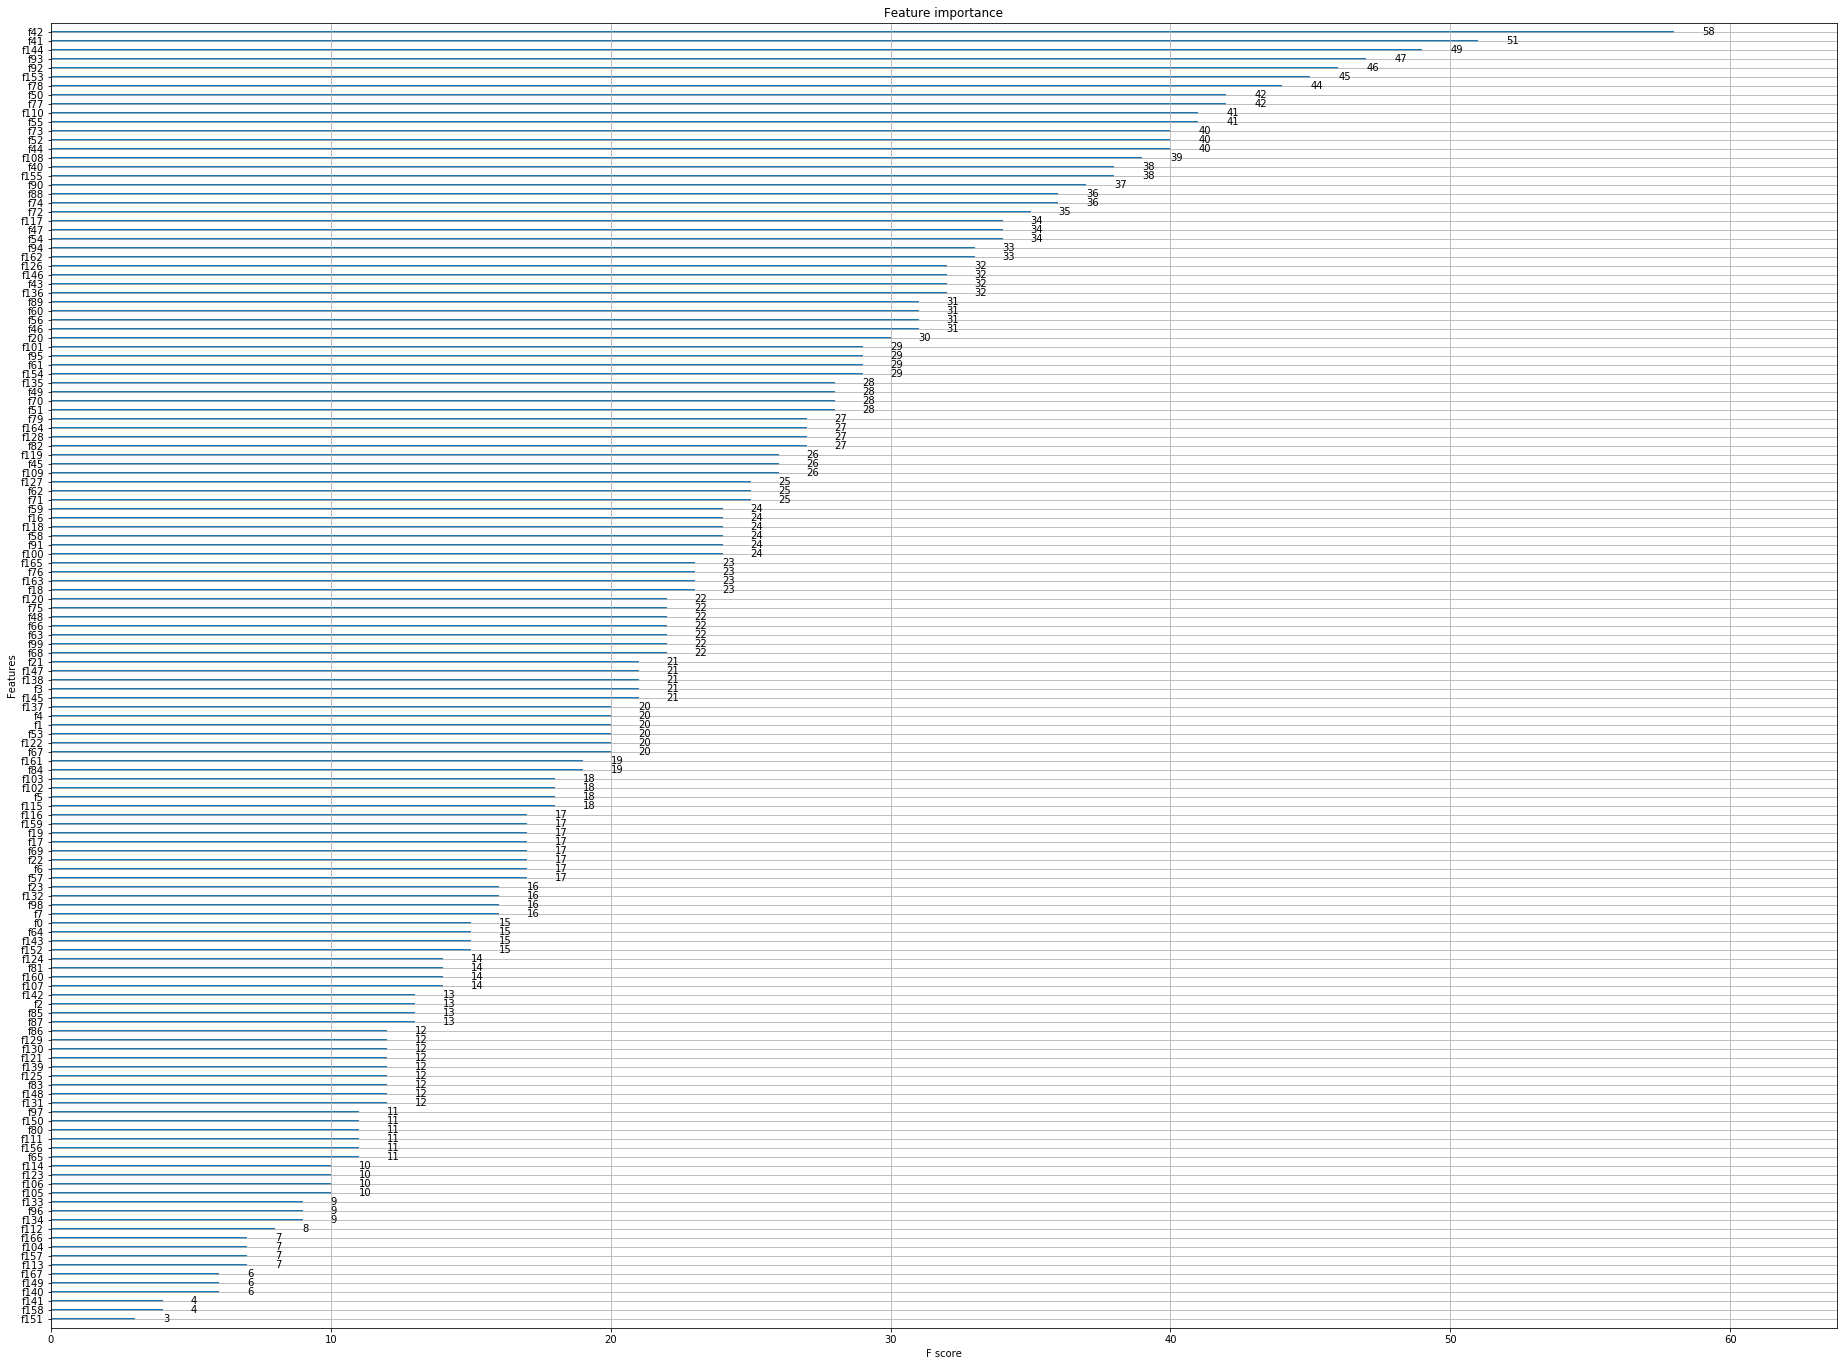

In [100]:
plt.rcParams["figure.figsize"] = (32,24)
plot_importance(model)
plt.show()

In [593]:
y_02[200]

1

(array([  5.,  16., 202.,  32.,   1.]),
 array([-5., -3., -1.,  1.,  3.,  5.], dtype=float32),
 <a list of 5 Patch objects>)

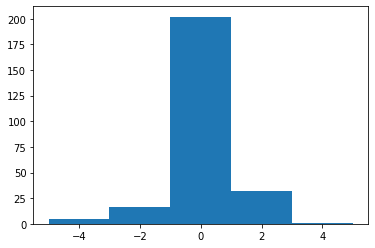

In [648]:
plt.hist(x[1000,:,1],bins=bins,range=HIST_range)

In [7]:
feature.mean(axis=1)

array([1820.74390164, 1794.98282657, 1366.77049128, ..., 3368.58514734,
       3150.73227432, 2575.55319812])

In [139]:
y_pred_ta=model.predict(x_train)
train = metrics.accuracy_score(y_train,y_pred_ta)

Text(0.5, 1.0, 'accuracy with all patitents(not whole data)')

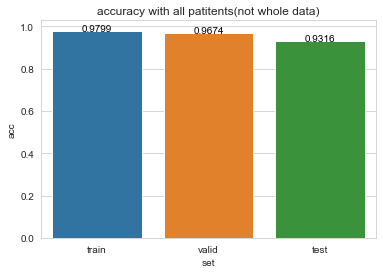

In [140]:
sns.set_style('whitegrid')
acc = pd.Series([train,valid,test])
set_ = pd.Series(['train','valid','test'])
df = pd.DataFrame({'set':set_,'acc':acc})
plt.figure(figsize=(6,4))
g=sns.barplot(x='set',y='acc',data=df)
for index,row in df.iterrows():
    g.text(row.name,row.acc,round(row.acc,4),color='black', ha="center")
    #print(row)
plt.title('accuracy with all patitents(not whole data)')

In [357]:
df_cm=pd.DataFrame(c_m,index=['actual_N','actual_P'],columns=['predict_N','predict_P'])

In [358]:
df_cm

,predict_N,predict_P
actual_N,143422,320
actual_P,186,30715


In [144]:
acc = {'1':P940}

In [173]:
acc['6']=P940

In [174]:
df = pd.DataFrame({'set':list(acc.keys()),'acc':list(acc.values())})

In [175]:
df

,set,acc
0,1,0.989645
1,2,0.956845
2,3,0.907104
3,4,0.892399
4,5,0.964222
5,6,0.918367


Text(0.5, 1.0, 'accuracy on some of rest dataset')

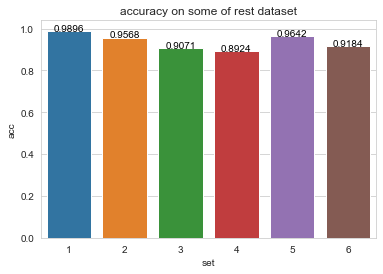

In [176]:
plt.figure(figsize=(6,4))
g=sns.barplot(x='set',y='acc',data=df)
for index,row in df.iterrows():
    g.text(row.name,row.acc,round(row.acc,4),color='black', ha="center")
    #print(row)
plt.title('accuracy on some of rest dataset')

In [320]:
list(acc.values())

[1.0,
 0.9959677419354839,
 0.9950920245398773,
 0.9472913616398243,
 0.9685792349726776]

In [ ]:
y_01